# Исследование объявлений о продаже квартир

Задача — установить параметры, влияющие на рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

Данные — архив объявлений сервиса Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.   
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:**

* определить рыночную стоимость объектов недвижимости;
* установить параметры влияющие на стоимость объектов недвижимости;
* предоставить данные для построения автоматизированной системы, которая отследит аномалии и мошенническую деятельность.

**Этапы исследования:**

* обзор данных,
* предобработка данных,
* расчет и добавление новых столбцов,
* выявление параметров влияющих на стоимость квартиры,
* общий вывод.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
try:    
    data = pd.read_csv('real_estate_data.csv' , sep = '\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
data_check = data
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Рассмотрим количественное распределение объявлений о продаже по всем параметрам.

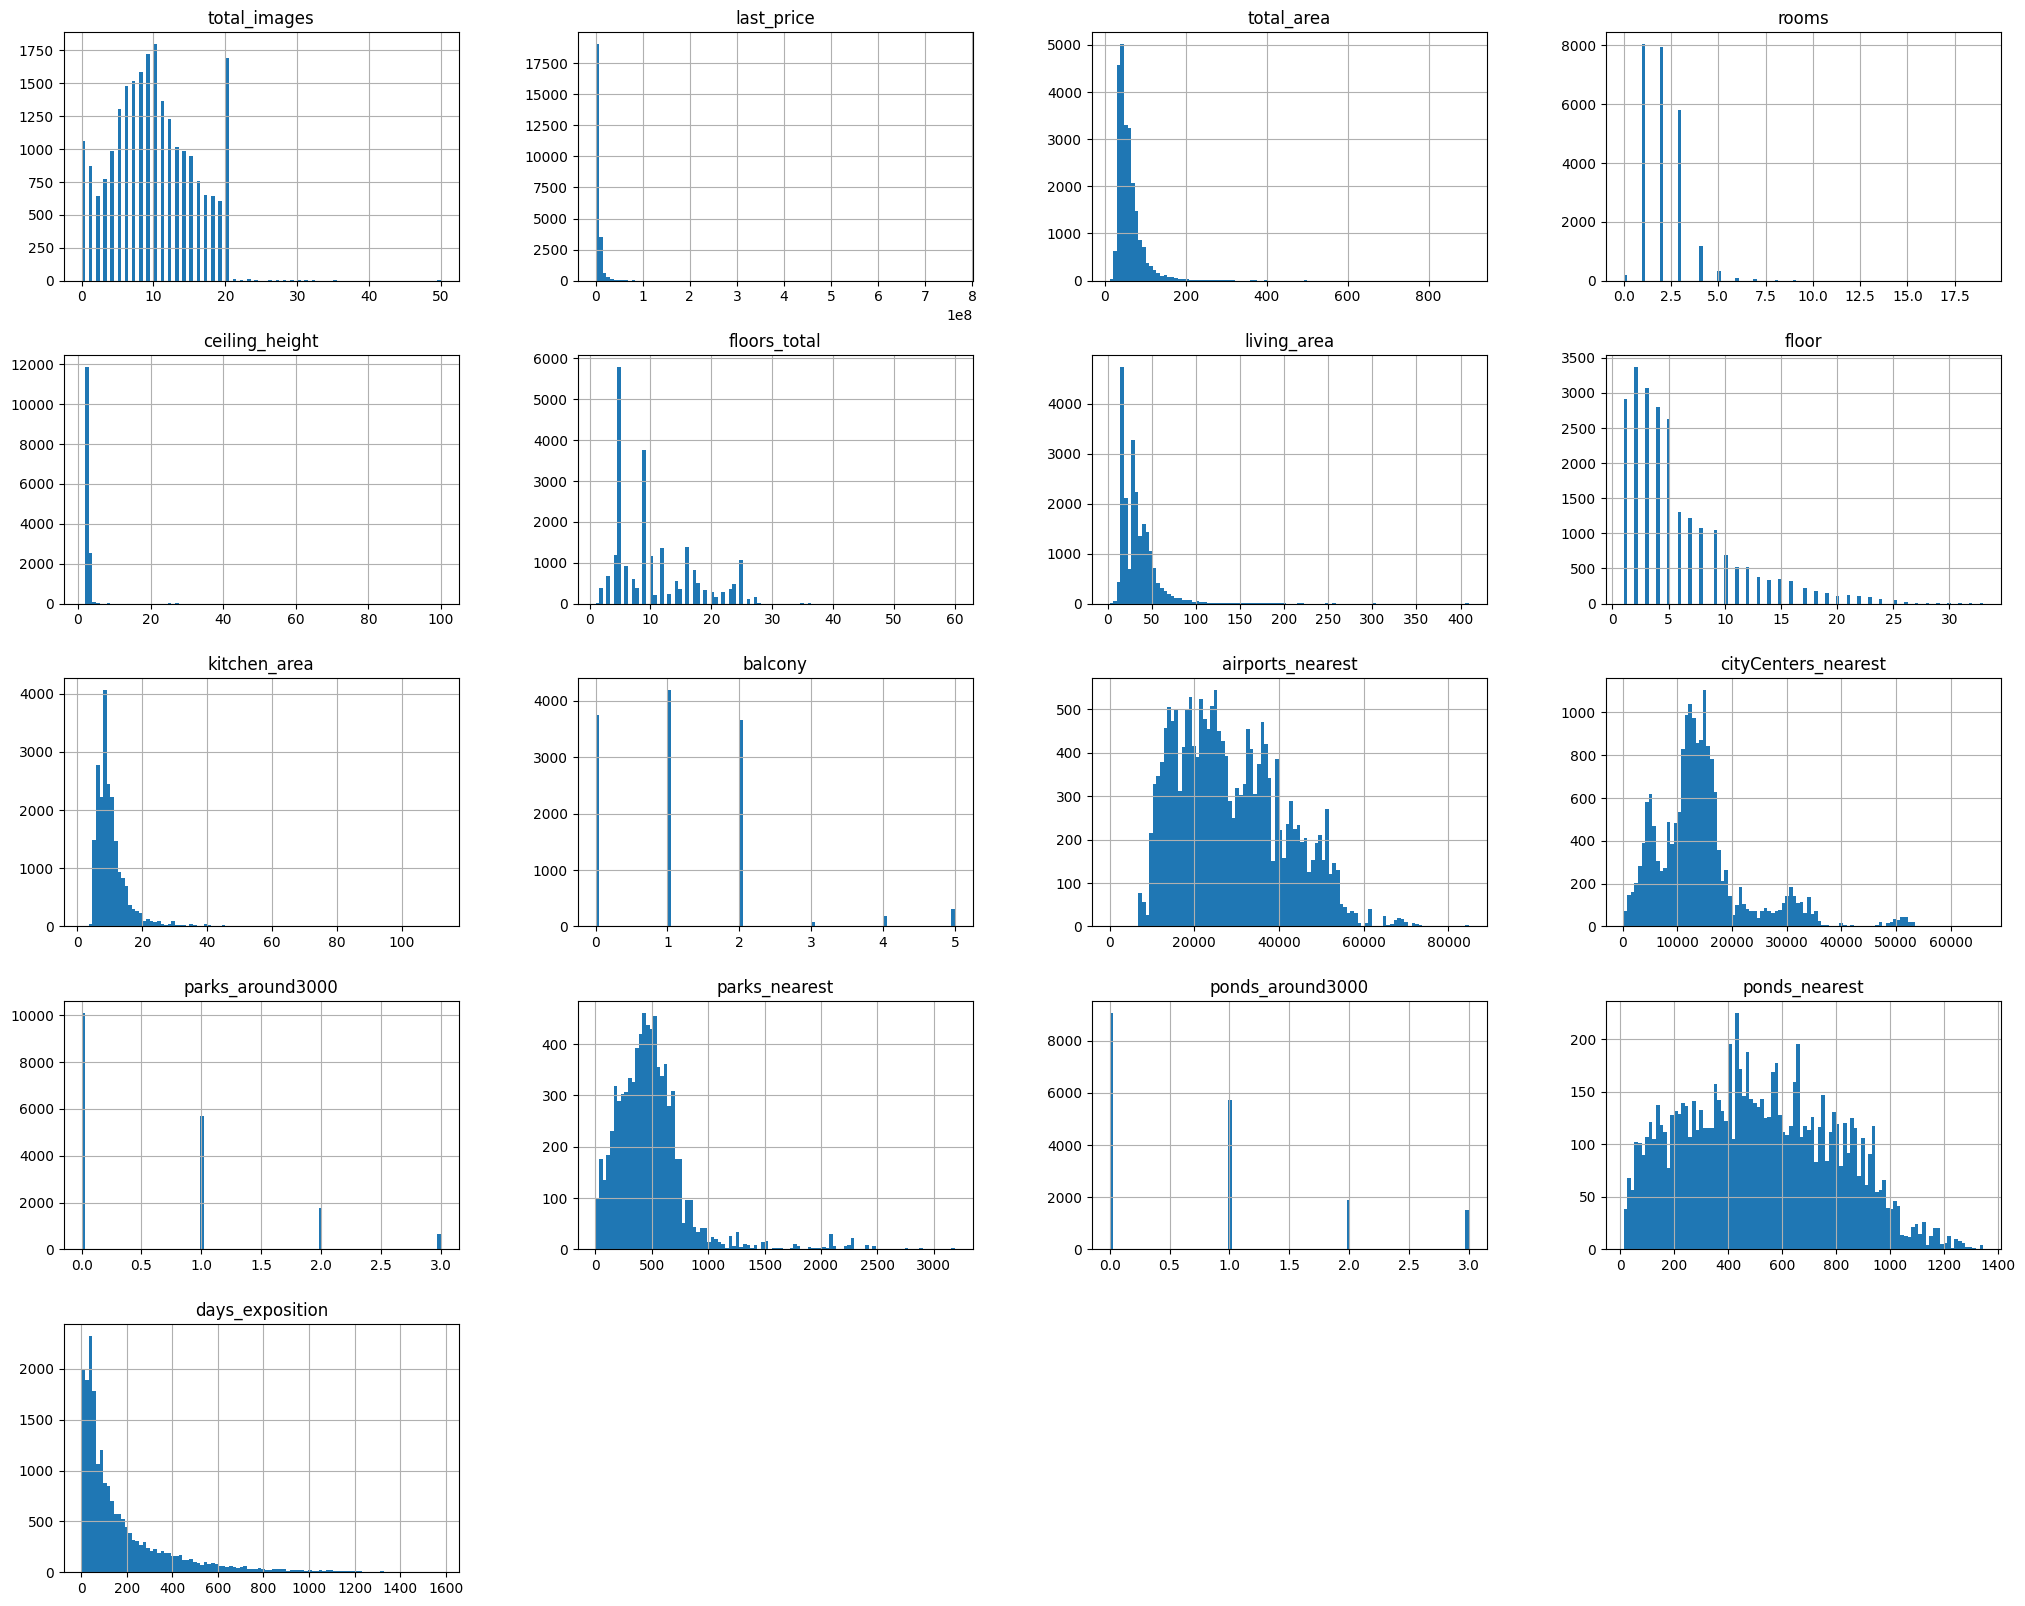

In [5]:
data.hist(bins = 100 , figsize= (25,20));

## Предобработка данных

Проверим данные на дубликаты

In [6]:
data.duplicated().sum()

0

Ознакомимся с пропусками

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


### Цена

В рамках предобработки данных ознакомимся со значениями цен из столбца `last_price`.

Для удобства переведем формат цены из руб. в тыс.руб.

In [8]:
data['last_price'] = (data['last_price'] / 1000).round(1)

In [9]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN


Далее посмотрим что за значения находятся в столбце, проверим на аномалии.

In [10]:
data['last_price'].describe()

count     23699.000000
mean       6541.548753
std       10887.013289
min          12.200000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

Очевидно, что есть аномально высокие значения и аномально низкие. Рассмотрим их по порядку.

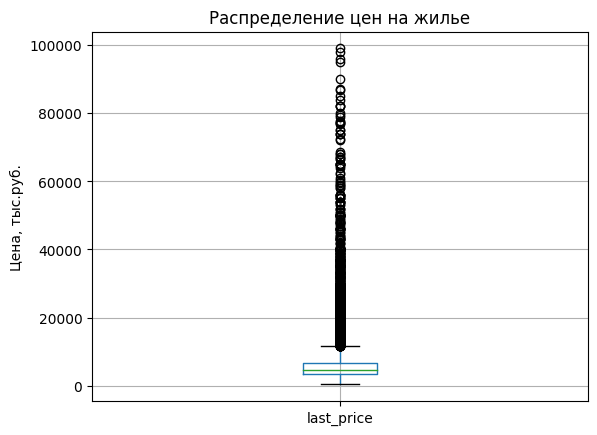

In [229]:
data.boxplot('last_price')
plt.title('Распределение цен на жилье')
plt.ylabel('Цена, тыс.руб.')
plt.show()

Есть несколько аномально высоких значений выбросов. Вероятно, данные объявления относятся к дворцовым помещениям) 

Отсечем значения выше 100 млн.руб.

Но прежде чем отсекать, посмотрим количество этих значений.

In [12]:
data.loc[data['last_price'] > 100000 , 'last_price'].value_counts().sum()

37

In [13]:
data = data.query('last_price < 100000')

count    23569.000000
mean      6159.013586
std       5982.799426
min        430.000000
25%       3400.000000
50%       4600.000000
75%       6750.000000
max      99000.000000
Name: last_price, dtype: float64

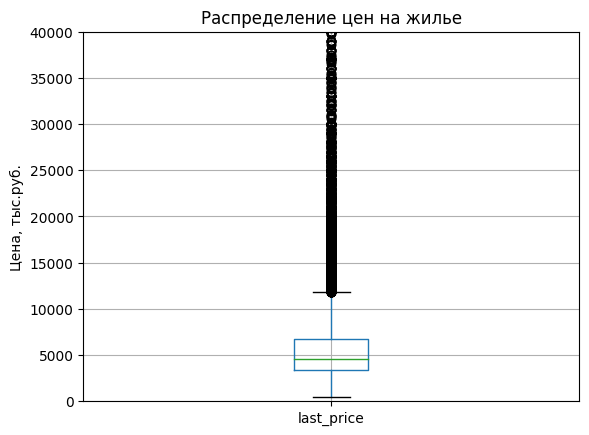

In [230]:
display(data['last_price'].describe())
data.boxplot('last_price')
plt.ylim(0 , 40000)
plt.title('Распределение цен на жилье')
plt.ylabel('Цена, тыс.руб.')
plt.show()

Коробка с усами все еще говорит про выбросы, линия прерывистая, видны отдельные значения, но дальше отсекать думаю не стоит, тк иначе наша выборка останется без элитного жилья.

Теперь рассмотрим минимальные значения.

In [15]:
data.sort_values(by = 'last_price', ascending = True).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12.2,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
14911,5,430.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,...,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
17456,7,430.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,...,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16274,18,440.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
9581,7,450.0,43.4,2018-08-31T00:00:00,2,NaN,5.0,30.3,3,NaN,...,5.5,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0


Минимальное значение выбивается, вероятно неправильно указали разряд величины стоимости. Посмотрю, есть ли значения с похожими параметрами 

In [16]:
data.query('95 < total_area < 125 and '
           '2.55 < ceiling_height < 2.95 and '
           '25 < living_area < 40 and '
           'locality_name == "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5477,12,15200.0,96.00,2018-03-23T00:00:00,3,2.70,16.0,34.5,7,NaN,...,34.19,NaN,Санкт-Петербург,15903.0,7953.0,1.0,1053.0,0.0,NaN,NaN
5651,6,14501.0,96.64,2017-11-16T00:00:00,2,2.72,10.0,37.4,4,NaN,...,23.80,NaN,Санкт-Петербург,28220.0,6923.0,1.0,956.0,3.0,708.0,113.0
5861,16,17480.0,105.60,2018-09-04T00:00:00,2,2.70,13.0,39.7,12,False,...,44.90,2.0,Санкт-Петербург,30782.0,8154.0,0.0,NaN,2.0,424.0,115.0
6021,19,16830.0,117.40,2019-04-04T00:00:00,2,2.75,16.0,33.4,13,NaN,...,51.00,2.0,Санкт-Петербург,51030.0,14721.0,0.0,NaN,0.0,NaN,NaN
8112,20,14400.0,95.30,2019-04-16T00:00:00,3,2.80,25.0,38.3,11,NaN,...,33.90,2.0,Санкт-Петербург,36533.0,9289.0,1.0,674.0,0.0,NaN,NaN
8793,7,12.2,109.00,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.50,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9362,19,11990.0,108.00,2017-09-03T00:00:00,3,2.70,17.0,39.0,5,NaN,...,36.00,1.0,Санкт-Петербург,14741.0,12665.0,0.0,NaN,0.0,NaN,32.0
10563,20,12700.0,97.90,2019-04-16T00:00:00,2,2.60,17.0,31.7,16,NaN,...,34.70,NaN,Санкт-Петербург,14932.0,11348.0,1.0,36.0,1.0,274.0,NaN
12283,4,18326.0,105.00,2019-04-16T00:00:00,3,2.70,13.0,38.1,3,NaN,...,30.00,NaN,Санкт-Петербург,27314.0,9260.0,0.0,NaN,0.0,NaN,NaN
13440,17,18000.0,99.10,2017-07-10T00:00:00,3,2.75,6.0,39.0,5,NaN,...,33.10,0.0,Санкт-Петербург,23390.0,2254.0,2.0,425.0,1.0,62.0,39.0


Есть похожие значения, исправим рассматриваемое домножив его на 1000.

In [17]:
data.loc[data['last_price'] == 12.2 , 'last_price'] =\
data.loc[data['last_price'] == 12.2 , 'last_price'] * 1000

In [18]:
data.query('99 < total_area < 119 and '
           '2.65 < ceiling_height < 2.85 and '
           '27 < living_area < 37 and '
           'locality_name == "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
6021,19,16830.0,117.4,2019-04-04T00:00:00,2,2.75,16.0,33.4,13,NaN,...,51.0,2.0,Санкт-Петербург,51030.0,14721.0,0.0,NaN,0.0,NaN,NaN
8793,7,12200.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
16964,15,16500.0,101.3,2017-12-18T00:00:00,3,2.80,18.0,32.9,10,NaN,...,55.7,NaN,Санкт-Петербург,30766.0,8059.0,0.0,NaN,1.0,213.0,442.0


Посмотрим распределение количества объявлений в зависимости от стоимости.

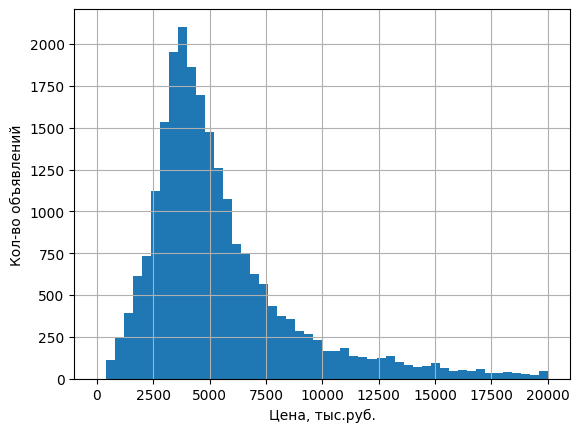

In [233]:
data['last_price'].hist(bins = 50 , range = (0, 20000))
plt.xlabel('Цена, тыс.руб.')
plt.ylabel('Кол-во объявлений')
plt.show()

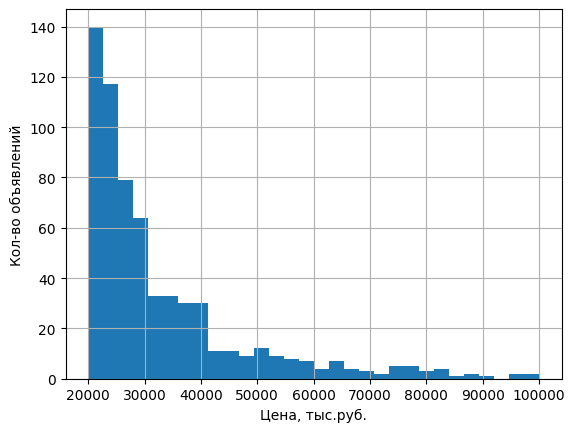

In [238]:
data['last_price'].hist(bins = 30 , range = (20000 , 100000))
plt.xlabel('Цена, тыс.руб.')
plt.ylabel('Кол-во объявлений')
plt.show()

Гистограммы показывают логичное понижение количества объявлений с увеличением цены. Наибольшее количество объявлений находится в пределах 3-5 млн.руб.

### Жилая площадь

В рамках предобработки данных ознакомимся со значениями жилых площадей из столбца `living_area`.

In [21]:
data[data['living_area'] > 0].sort_values(by = 'living_area' , ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5358,20,65000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,NaN,...,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
12401,20,91500.0,495.0,2017-06-19T00:00:00,7,4.65,7.0,347.5,7,NaN,...,25.0,0.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0
4237,1,50000.0,517.0,2017-10-14T00:00:00,7,NaN,4.0,332.0,3,NaN,...,22.0,NaN,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
660,3,49950.0,483.9,2017-10-04T00:00:00,7,3.20,6.0,312.5,4,NaN,...,26.4,NaN,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
8018,20,84000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,...,45.5,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17582,11,2680.0,22.0,2018-08-11T00:00:00,0,NaN,25.0,5.0,8,NaN,...,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
3242,7,4440.0,41.0,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,...,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
23574,14,64990.0,139.0,2015-11-24T00:00:00,3,3.00,8.0,3.0,8,NaN,...,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
13915,20,6350.0,52.0,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,NaN,...,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0


In [22]:
data['living_area'].describe()

count    21764.000000
mean        34.251632
std         21.175156
min          2.000000
25%         18.600000
50%         30.000000
75%         42.200000
max        409.000000
Name: living_area, dtype: float64

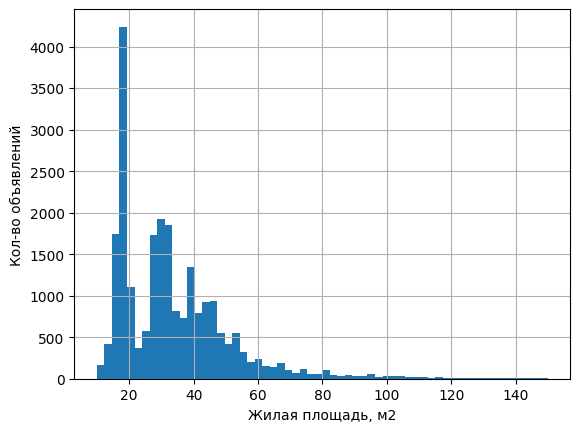

In [240]:
data['living_area'].hist(bins = 60 , range = (10, 150))
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Кол-во объявлений')
plt.show()

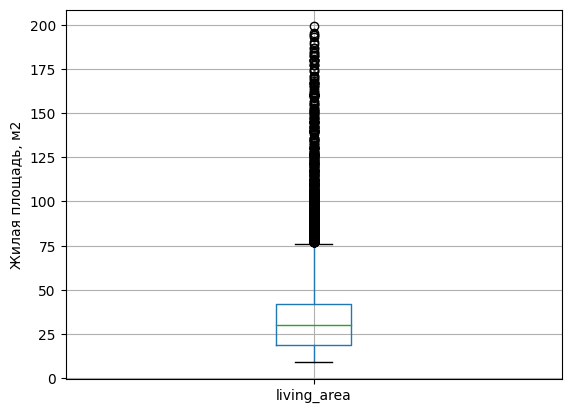

In [241]:
data.boxplot('living_area' )
plt.ylabel('Жилая площадь, м2')
plt.show()

Текущая норма жилой площади на человека в СПб составляет 9 кв. метров для жильцов отдельных квартир и 15 кв.метров для обладателей собственности в коммуналке. 
По максимальным значениям нормы нет. 

Гистограмма показывает пики значения 17м2 и 30м2 и между ними просадка, пока неизвестно с чем связанная.

Большая часть площадей находится в промежутке от 15 до 75м2. Вероятно, жилье с жилой площадью более 75м2 является элитным жильем.

Для начала избавимся от аномальных значений. Минмальным значением примем 9, по нормам жилых площадей. Максимальным значением  возьмем 200м2, поскольку там начинают прерываться "выбросы" коробки с усами. 

Оставим промежуток 9 < `living_area` < 200.

От остальных выбросов вероятно избавимся во время последующего анализа.

In [25]:
# расчет количества объявлений с аномальной жилой площадью
display(data.loc[data['living_area'] > 200 , 'living_area'].value_counts().sum())
data.loc[data['living_area'] < 9 , 'living_area'].value_counts().sum()

21

14

Удаляю 35 значений.

In [26]:
data = data.query('(living_area.isnull()) or (9 < living_area < 200)')

**Заполнение пропусков**

Заполнить пустые значения можно медианным значением жилой площади от общей площади.

Поскольку, в жилых и общих площадях есть нецелые значения, для последующей группировки округлю их до целых и переведу формат в int64.

In [242]:
# Округляю значения
data['living_area'] = data['living_area'].round()
data['total_area'] = data['total_area'].round()

In [243]:
# перевожу значения в целочисленный формат для удобства
data['total_area'] = data['total_area'].astype('int64')

In [30]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000.0,108,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350.0,40,2018-12-04T00:00:00,1,NaN,11.0,19.0,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [31]:
# Нахожу медианные значения жилой площади, сгруппировав по значениям общей площади
living_median = data.groupby('total_area')['living_area'].agg('median').reset_index()

In [32]:
# Перименовываю колонки
living_median.columns = ['total_area' , 'median_living']

In [33]:
# Присоединяю living_median к датафрейму
data = data.merge(living_median, on = 'total_area' , how='left')

In [34]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living
0,20,13000.0,108,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,61.0
1,7,3350.0,40,2018-12-04T00:00:00,1,NaN,11.0,19.0,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,18.0
2,10,5196.0,56,2015-08-20T00:00:00,2,NaN,5.0,34.0,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,33.0
3,0,64900.0,159,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,95.0


In [35]:
# Заменяю пустые значения из living_area на медианные значения из median_living
data['living_area'] = np.where(
    data['living_area'].isna(), 
    data['median_living'] , 
    data['living_area']
)

In [36]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living
0,20,13000.0,108,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,61.0
1,7,3350.0,40,2018-12-04T00:00:00,1,NaN,11.0,19.0,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,18.0
2,10,5196.0,56,2015-08-20T00:00:00,2,NaN,5.0,34.0,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,33.0
3,0,64900.0,159,2015-07-24T00:00:00,3,NaN,14.0,95.0,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,95.0


In [300]:
#количество оставшихся пропусков
data['living_area'].isna().sum()

6

Оставшиеся 13 пропусков оставляю.

### Общая площадь

In [39]:
data['total_area'].describe()

count    23616.000000
mean        59.608401
std         31.654203
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        494.000000
Name: total_area, dtype: float64

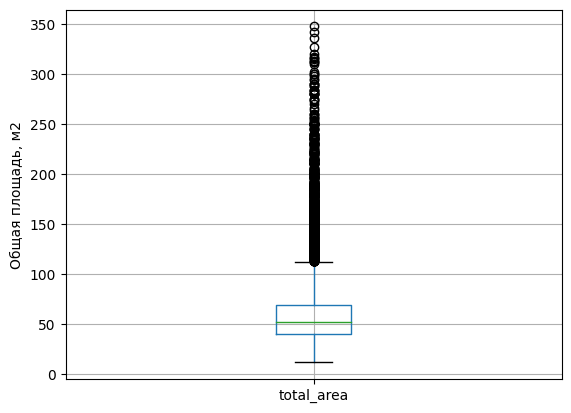

In [245]:
data.boxplot(column = 'total_area' );
plt.ylabel('Общая площадь, м2')
plt.show()

Минимальное значение общей площади - 12м2. Касаемо стандартов минимальной общей площади, я не нашел никакой информации. 

После 350м2 видно несколько разрозненных выбросов.

Удалю их.

In [41]:
# расчет количества аномальных объявлений с площадью квартир >350 м2
data.loc[data['total_area'] > 350 , 'total_area'].value_counts().sum()

14

**Отсечение**

In [42]:
data = data.query('total_area < 350')

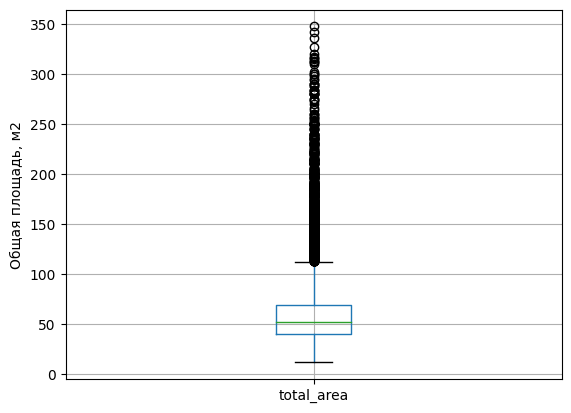

In [246]:
data.boxplot('total_area' )
plt.ylabel('Общая площадь, м2')
plt.show()

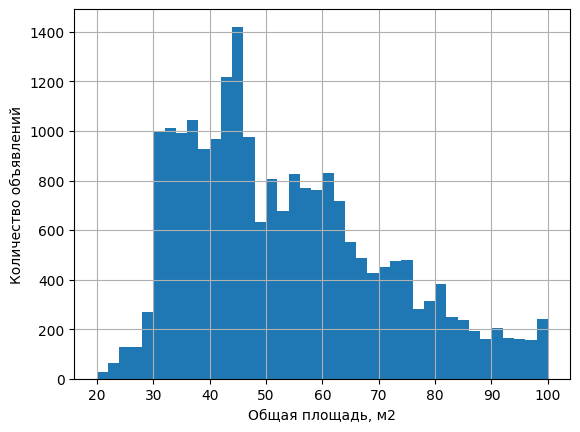

In [250]:
data['total_area'].hist(bins = 40, range = (20, 100))
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объявлений')
plt.show()

### Высота потолка

In [46]:
data['ceiling_height'].sort_values(ascending = False).unique()

array([100.  ,  32.  ,  27.5 ,  27.  ,  26.  ,  25.  ,  24.  ,  22.6 ,
        20.  ,  14.  ,  10.3 ,   8.3 ,   8.  ,   5.8 ,   5.5 ,   5.3 ,
         5.2 ,   5.  ,   4.8 ,   4.7 ,   4.5 ,   4.45,   4.4 ,   4.37,
         4.3 ,   4.25,   4.2 ,   4.19,   4.15,   4.14,   4.1 ,   4.06,
         4.  ,   3.98,   3.95,   3.93,   3.9 ,   3.88,   3.87,   3.86,
         3.85,   3.84,   3.83,   3.8 ,   3.78,   3.76,   3.75,   3.7 ,
         3.69,   3.68,   3.67,   3.66,   3.65,   3.63,   3.62,   3.6 ,
         3.59,   3.58,   3.57,   3.56,   3.55,   3.54,   3.53,   3.52,
         3.51,   3.5 ,   3.49,   3.48,   3.47,   3.46,   3.45,   3.44,
         3.43,   3.42,   3.4 ,   3.39,   3.38,   3.37,   3.36,   3.35,
         3.34,   3.33,   3.32,   3.31,   3.3 ,   3.29,   3.28,   3.27,
         3.26,   3.25,   3.24,   3.23,   3.22,   3.21,   3.2 ,   3.18,
         3.17,   3.16,   3.15,   3.14,   3.13,   3.12,   3.11,   3.1 ,
         3.09,   3.08,   3.07,   3.06,   3.05,   3.04,   3.03,   3.02,
      

Видны аномально высокие и аномально низкие значения.



Минимальной нормой для квартир в РФ считается 2.4 метра. 
В Санкт-Петербурге в домах старого жилого фонда высота потолков может достигать 5 метров.

Возьмем минимальное значение для потолков - 2 метра и максимальное - 6 метров.

Значения в пределах от 20 метров до 32 метров предлагаю разделить на 10, поскольку тут явная ошибка в порядках.

Но перед тем как отсекать все остальные, посмотрим их количество - какую часть от общего количества строк они составляют. 

In [47]:
# делю значения высот потолков в пределах от 20 до 30 метров на 10
data.loc[(data['ceiling_height'] >= 20) & 
         (data['ceiling_height'] <= 32) , 'ceiling_height'] = \
data.loc[(data['ceiling_height'] >= 20) & 
         (data['ceiling_height'] <= 32) , 'ceiling_height'] / 10

In [48]:
data['ceiling_height'].sort_values(ascending = False).unique()

array([100.  ,  14.  ,  10.3 ,   8.3 ,   8.  ,   5.8 ,   5.5 ,   5.3 ,
         5.2 ,   5.  ,   4.8 ,   4.7 ,   4.5 ,   4.45,   4.4 ,   4.37,
         4.3 ,   4.25,   4.2 ,   4.19,   4.15,   4.14,   4.1 ,   4.06,
         4.  ,   3.98,   3.95,   3.93,   3.9 ,   3.88,   3.87,   3.86,
         3.85,   3.84,   3.83,   3.8 ,   3.78,   3.76,   3.75,   3.7 ,
         3.69,   3.68,   3.67,   3.66,   3.65,   3.63,   3.62,   3.6 ,
         3.59,   3.58,   3.57,   3.56,   3.55,   3.54,   3.53,   3.52,
         3.51,   3.5 ,   3.49,   3.48,   3.47,   3.46,   3.45,   3.44,
         3.43,   3.42,   3.4 ,   3.39,   3.38,   3.37,   3.36,   3.35,
         3.34,   3.33,   3.32,   3.31,   3.3 ,   3.29,   3.28,   3.27,
         3.26,   3.25,   3.24,   3.23,   3.22,   3.21,   3.2 ,   3.18,
         3.17,   3.16,   3.15,   3.14,   3.13,   3.12,   3.11,   3.1 ,
         3.09,   3.08,   3.07,   3.06,   3.05,   3.04,   3.03,   3.02,
         3.01,   3.  ,   2.99,   2.98,   2.97,   2.96,   2.95,   2.94,
      

In [49]:
display(data.loc[data['ceiling_height'] > 6 , 'ceiling_height'].value_counts().sum())
data.loc[data['ceiling_height'] < 2 , 'ceiling_height'].value_counts().sum()

7

3

 Получается всего 10 значений. Избавляемся.

**Отсечение**

In [50]:
data = data.query('(ceiling_height.isnull()) or (2 < ceiling_height < 6)')

In [51]:
data['ceiling_height'].sort_values(ascending = False).unique()

array([5.8 , 5.5 , 5.3 , 5.2 , 5.  , 4.8 , 4.7 , 4.5 , 4.45, 4.4 , 4.37,
       4.3 , 4.25, 4.2 , 4.19, 4.15, 4.14, 4.1 , 4.06, 4.  , 3.98, 3.95,
       3.93, 3.9 , 3.88, 3.87, 3.86, 3.85, 3.84, 3.83, 3.8 , 3.78, 3.76,
       3.75, 3.7 , 3.69, 3.68, 3.67, 3.66, 3.65, 3.63, 3.62, 3.6 , 3.59,
       3.58, 3.57, 3.56, 3.55, 3.54, 3.53, 3.52, 3.51, 3.5 , 3.49, 3.48,
       3.47, 3.46, 3.45, 3.44, 3.43, 3.42, 3.4 , 3.39, 3.38, 3.37, 3.36,
       3.35, 3.34, 3.33, 3.32, 3.31, 3.3 , 3.29, 3.28, 3.27, 3.26, 3.25,
       3.24, 3.23, 3.22, 3.21, 3.2 , 3.18, 3.17, 3.16, 3.15, 3.14, 3.13,
       3.12, 3.11, 3.1 , 3.09, 3.08, 3.07, 3.06, 3.05, 3.04, 3.03, 3.02,
       3.01, 3.  , 2.99, 2.98, 2.97, 2.96, 2.95, 2.94, 2.93, 2.92, 2.91,
       2.9 , 2.89, 2.88, 2.87, 2.86, 2.85, 2.84, 2.83, 2.82, 2.81, 2.8 ,
       2.79, 2.78, 2.77, 2.76, 2.75, 2.74, 2.73, 2.72, 2.71, 2.7 , 2.69,
       2.68, 2.67, 2.66, 2.65, 2.64, 2.63, 2.62, 2.61, 2.6 , 2.59, 2.58,
       2.57, 2.56, 2.55, 2.54, 2.53, 2.52, 2.51, 2.

In [52]:
data['ceiling_height'].isna().sum()

9164

Заполнить пропуски кажется проблематичным. От площади высота потолка не зависит, тип жилья тоже не влияет. Возможно влияет расположение. В центре Петербурга преобладает старая застройка и скорее всего потолки будут по большей части высокие. На окраинах в новостройках будут преобладать средние и низкие значения. В пригородах, среди хрущевок и новостроек, так же будут преобладать средние и низкие значения.

Поскольку в данный момент столбец с населенными пунктами еще не обработан, то заполню пустые значения после его обработки ниже.

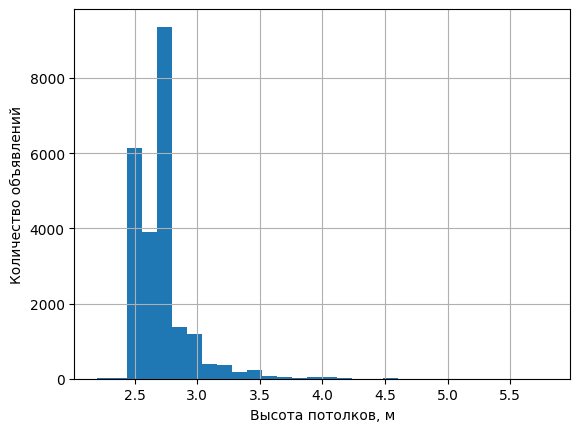

In [251]:
data['ceiling_height'].hist(bins = 30)
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество объявлений')
plt.show()

### Дата

Поменяю формат даты и времени на удобный для анализа.

In [54]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'] ,
                                              format = '%Y-%m-%d %H:%M:%S')

In [55]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,61.0


### Расстояние до аэропорта и до центра

В настоящий момент расстояние указано в метрах. Переведу значения в километры, разделив значения на 1000.

In [56]:
data['airports_nearest'] = (data['airports_nearest'] / 1000).round()
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).round()

In [57]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0
1,7,3350.0,40,2018-12-04,1,NaN,11.0,19.0,1,NaN,...,2.0,посёлок Шушары,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0


### Балконы

In [59]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Пропущенные значения у балконов можно объяснить тем, что их просто нет. Поэтому меняем все пропуски на нули.

In [60]:
data['balcony']= data['balcony'].fillna(0)

In [61]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9164
floors_total               86
living_area                 6
floor                       0
is_apartment            20814
studio                      0
open_plan                   0
kitchen_area             2257
balcony                     0
locality_name              49
airports_nearest         5527
cityCenters_nearest      5506
parks_around3000         5505
parks_nearest           15574
ponds_around3000         5505
ponds_nearest           14542
days_exposition          3158
median_living               6
dtype: int64

In [62]:
# Меняю формат на int64
data['balcony'] = data['balcony'].astype('int64')

In [63]:
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

Количество балконов 4 и 5 - похоже на аномалию. Посмотрю распределение количества таких квартир в зависимости от общей площади квартиры.

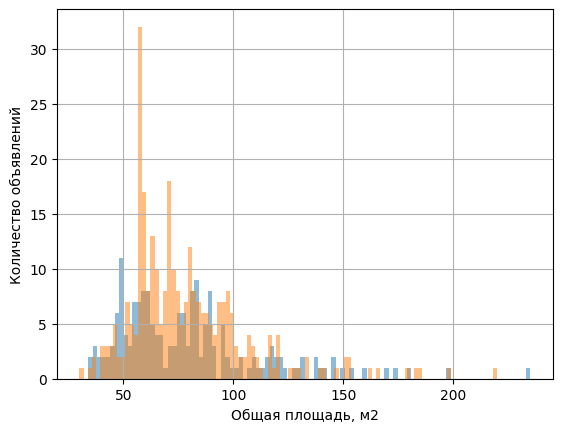

In [254]:
data.query('balcony == 4')['total_area'].hist(bins = 100 , alpha = 0.5)
data.query('balcony == 5')['total_area'].hist(bins = 100, alpha = 0.5)
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объявлений')
plt.show()

In [65]:
display(data.query('balcony == 4')['total_area'].count())
data.query('balcony == 5')['total_area'].count()

183

300

Немного странная картина - столько квартир малой площади с четырьмя и пятью балконами. Вероятно это аномальные значения. Можно их удалить, можно пересчитать. С другой стороны, количество балконов это вторичный параметр, который скорее всего не будет учитываться в анализе.

### Апартаменты

In [66]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Данные в столбце говорят о том, является ли данный объект апартаментами и имеют булев тип данных.

Я предполагаю, что пропуски связаны с тем, что при заполнении заявки на размещение объявления на сайте, пользователь просто пропускал данную строку, поскольку его объект не является апартаментами.

Считаю, что все пропуски необходимо заменить на значение `False`.

In [67]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts()

False    23532
True        48
Name: is_apartment, dtype: int64

### Кухня

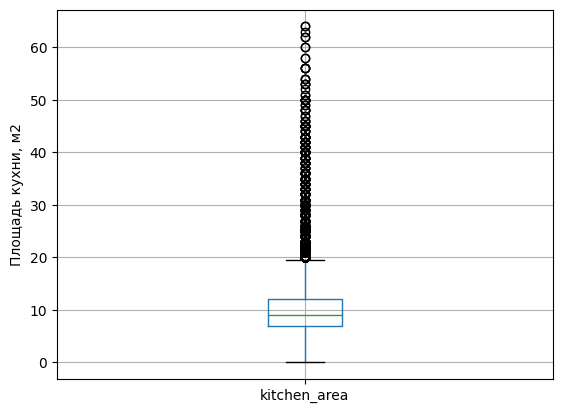

In [255]:
data.boxplot('kitchen_area')
plt.ylabel('Площадь кухни, м2')
plt.show()

Имеются выбивающиеся высокие значения > 65м2. Считаю, что стоит их удалить.


In [69]:
data.loc[data['kitchen_area'] >= 65 , 'kitchen_area'].value_counts().sum()

11

In [70]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9164
floors_total               86
living_area                 6
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2257
balcony                     0
locality_name              49
airports_nearest         5527
cityCenters_nearest      5506
parks_around3000         5505
parks_nearest           15574
ponds_around3000         5505
ponds_nearest           14542
days_exposition          3158
median_living               6
dtype: int64

**Удаление**

In [71]:
data = data.query('(kitchen_area.isnull()) or (kitchen_area < 65)')

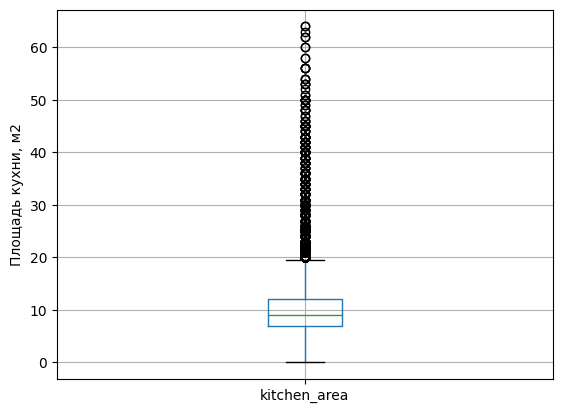

In [257]:
data.boxplot('kitchen_area')
plt.ylabel('Площадь кухни, м2')
plt.show()

Далее посмотрим пропуски и попробуем их заменить.

In [73]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9158
floors_total               86
living_area                 6
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2257
balcony                     0
locality_name              49
airports_nearest         5527
cityCenters_nearest      5506
parks_around3000         5505
parks_nearest           15571
ponds_around3000         5505
ponds_nearest           14539
days_exposition          3156
median_living               6
dtype: int64

**Замена пропусков**

По идее заполнить пропуски в площади кухонь можно медианным значением, группируя по общей площади квартиры.

Часть пропусков можно объяснить типом жилого помещения. По идее в жилом помещении со свободной планировкой и в квартире-студии нет обособленной кухни, они входят в общую площадь. На всякий случай проверю.

In [74]:
display(data.query('kitchen_area.isna() and studio == True')['last_price'].count())
data.query('kitchen_area.notna() and studio == True')['last_price'].count()

147

0

In [75]:
display(data.query('kitchen_area.isna() and open_plan == True')['last_price'].count())
data.query('kitchen_area.notna() and open_plan == True')['last_price'].count()

66

0

Так и есть. Заменю пропуски в данных категориях на ноль


In [76]:
data.loc[(data['kitchen_area'].isna()) & (data['studio'] == True) , 'kitchen_area'] = 0

In [77]:
data.loc[(data['kitchen_area'].isna()) & (data['open_plan'] == True) , 'kitchen_area'] = 0

In [78]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9158
floors_total               86
living_area                 6
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2044
balcony                     0
locality_name              49
airports_nearest         5527
cityCenters_nearest      5506
parks_around3000         5505
parks_nearest           15571
ponds_around3000         5505
ponds_nearest           14539
days_exposition          3156
median_living               6
dtype: int64

Далее заполним оставшиеся пропуски по медианным значениям

In [79]:
data['kitchen_area'] = data['kitchen_area'].round()

In [80]:
kitchen_median = data.groupby('total_area')['kitchen_area'].agg('median').reset_index()

In [81]:
kitchen_median.isna().count()

total_area      263
kitchen_area    263
dtype: int64

In [82]:
kitchen_median.columns = ['total_area' , 'median_kitchen']

In [83]:
data = data.merge(kitchen_median, on = 'total_area' , how='left')

In [84]:
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,Санкт-Петербург,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0
1,7,3350.0,40,2018-12-04,1,NaN,11.0,19.0,1,False,...,посёлок Шушары,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0
2,10,5196.0,56,2015-08-20,2,NaN,5.0,34.0,4,False,...,Санкт-Петербург,22.0,14.0,1.0,90.0,2.0,574.0,558.0,33.0,8.0


In [85]:
data['kitchen_area'] = np.where(data['kitchen_area'].isna() 
                               , data['median_kitchen'] , data['kitchen_area'])

In [86]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,Санкт-Петербург,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0
1,7,3350.0,40,2018-12-04,1,NaN,11.0,19.0,1,False,...,посёлок Шушары,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0


### Комнаты

In [87]:
data['rooms'].value_counts()

1     8022
2     7926
3     5797
4     1163
5      308
0      194
6       96
7       42
8        9
9        5
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64

Очевидно, среди комнат имеются аномальные значения. Рассмотрю строки с 8 и более комнатами

In [88]:
data.query('rooms > 7').sort_values(by = 'rooms' , ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen
18755,6,28500.0,270,2015-03-02,16,3.00,4.0,180.0,4,False,...,Санкт-Петербург,24.0,4.0,1.0,516.0,0.0,NaN,1365.0,180.0,13.0
20721,6,28659.0,245,2016-03-31,14,NaN,4.0,168.0,2,False,...,Санкт-Петербург,21.0,2.0,3.0,541.0,2.0,118.0,95.0,168.0,21.0
9636,8,33000.0,194,2017-02-07,11,3.43,5.0,129.0,2,False,...,Санкт-Петербург,21.0,1.0,1.0,686.0,2.0,66.0,813.0,129.0,12.0
644,3,17500.0,184,2018-07-01,11,3.40,7.0,139.0,7,False,...,Санкт-Петербург,24.0,3.0,0.0,NaN,0.0,NaN,NaN,129.5,19.5
18027,4,15500.0,216,2016-07-04,10,3.15,5.0,161.0,2,False,...,Санкт-Петербург,24.0,5.0,1.0,368.0,0.0,NaN,11.0,123.5,20.0
18798,11,40000.0,290,2016-06-21,10,3.50,6.0,189.0,6,False,...,Санкт-Петербург,26.0,5.0,3.0,316.0,1.0,227.0,77.0,180.0,30.0
4121,6,23000.0,273,2018-01-11,10,3.14,7.0,146.0,7,False,...,Санкт-Петербург,11.0,12.0,1.0,191.0,1.0,531.0,NaN,146.0,19.0
13336,14,19500.0,310,2016-02-03,9,NaN,5.0,199.0,5,False,...,Санкт-Петербург,10.0,10.0,2.0,352.0,0.0,NaN,468.0,199.0,14.0
9498,10,23500.0,313,2017-02-13,9,3.20,6.0,179.0,5,False,...,Санкт-Петербург,38.0,10.0,1.0,146.0,0.0,NaN,NaN,179.0,13.0
20683,0,24000.0,250,2019-04-23,9,3.20,5.0,161.0,3,False,...,Санкт-Петербург,10.0,10.0,2.0,352.0,0.0,NaN,NaN,118.0,28.0


Судя по большим площадям, значения не очень аномальные, но поскольку их очень мало, в последующих исследованиях учитывать их не стоит.

In [89]:
display(data.query('rooms == 0')['total_area'].count())
data.query("rooms == 0 and "
           "(is_apartment == True or open_plan == True or studio == True)")\
['total_area'].count()

194

194

Значение `0` справедливо только для жилых помещений типа апартаменты, студия или свободная планировка. Можно учесть это в дальнейших исследованиях.


### Населенные пункты

In [90]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

**Замена неявных дубликатов**

Среди населенных пунктов есть множество поселков, сел и деревень. Некоторые одинаковые по сути значения имеют разный порядок слов и тем самым создают неявные дубликаты. Некоторые значения дублируются из-за использования букв е/ё. Предлагаю удалить типы населенных пунктов и оставить только сами названия, а также все буквы "ё" заменить на "е".

*Также, можно было бы типы населенных пунктов вынести в отдельный столбец для последующей категоризации и оценке влияния типа населенного пункта на стоимость квартир. С другой стороны, с тем же успехом можно оценить стоимость квартир и по удаленности от центра северной столицы. Правда, в столбце с удаленностью от центра много пропущенных значений.*

In [91]:
# Понизим регистр всех наименований
data['locality_name'] = data['locality_name'].str.lower()

In [301]:
data['locality_name'] = data['locality_name'].replace("ё", "е" , regex = True)
len(data['locality_name'].unique())

307

Удалю типы поселений.

In [93]:
#удаление типов поселений
data['locality_name'] = data['locality_name'].replace('поселок ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('городского типа ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('деревня ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('село ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('городской ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('коттеджный ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('садовое товарищество ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('садоводческое некоммерческое товарищество ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('при железнодорожной станции ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('станции ' , '', regex = True)
data['locality_name'] = data['locality_name'].replace('садоводческое некоммерческое товарищество ' , '', regex = True)


len(data['locality_name'].sort_values().unique())

306

**Замена пропусков**

Глядя на пропуски в населенных пунктах и имеющиеся данные, у меня появилась идея как их заполнить.

Идея в том, чтобы сравнить эти значения со значениями расстояний для строк где населенный пункт известен и если они пересекаются, то заполнить пустое значение населенного пункта названием с которым пересеклись.

Я понимаю, что данный метод заполнения не идеальный по ряду причин:
* расстояние берется не по границам населенных пунктов, а по мин-макс значениям указанных в объявлениях,
* мало переменных для сравнения, то есть, я себе это представляю как пересечение двух окружностей определенных радиусов (расстояние до центра и до аэропорта). Была бы третья переменная, было бы гораздо точнее.
* данный метод может вернуть более одного значения,
* возвращаются категориальные значения, а не количественные, то есть меньше маневров для сглаживания неточностей.

В общем, мне стало интересно, как можно это осуществить не только применительно к проекту, но и в целом - определение неизвестного значения по сторонним известным параметрам в датафрейме.

Попробуем избавиться от пропусков в населенных пунктах (49 пропусков).
Можно поробовать восстановить данные.
Если в строках где пропущены названия городов будут известны значения следующих столбцов:
* `airports_nearest`,
* `cityCenters_nearest`,   

то можно попробовать по промежуткам между минимальным и максимальным значениями подобрать позиции с уже известными населенными пунктами.

In [94]:
#вывод мин-макс значений расстояния до центра города
locality_pivot = data.pivot_table(index = 'locality_name' , 
                                  values = 'cityCenters_nearest' , 
                                  aggfunc = ['min' , 'max']).reset_index()

In [95]:
#вывод мин-макс значений расстояния до аэропорта
locality_pivot2 = data.pivot_table(index = 'locality_name' , 
                                  values = 'airports_nearest' , 
                                  aggfunc = ['min' , 'max']).reset_index()

Функция для замены пропусков по расстоянию

In [96]:
for i, row in data.loc[data['locality_name'].isna()].iterrows():
    ccn = row['cityCenters_nearest']
    an = row['airports_nearest']
    if ccn == ccn:
        valid_cities_ccn = set(locality_pivot.loc[(locality_pivot[('min', 'cityCenters_nearest')] <= ccn)&
                                              (locality_pivot[('max', 'cityCenters_nearest')] >= ccn), 
                                              ('locality_name','')])
    else:
        valid_cities_ccn = set()
        
    if an == an:
        valid_cities_an = set(locality_pivot2.loc[(locality_pivot2[('min', 'airports_nearest')] <= an)&
                                              (locality_pivot2[('max', 'airports_nearest')] >= an), 
                                              ('locality_name','')])
    else:
        valid_cities_an = set()
    valid_set = valid_cities_ccn.intersection(valid_cities_an)
    
    if len(valid_set) == 1:
        data.loc[i, 'locality_name'] = list({'санкт-петербург'})[0]
    elif len(valid_set) > 1:
        data.loc[i, 'locality_name'] = 'неизвестно'

In [97]:
data.loc[data['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen
2016,6,5398.0,80,2017-05-30,3,NaN,4.0,43.0,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,47.0,13.0
14277,3,3611.0,54,2017-04-27,1,NaN,4.0,26.0,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,30.0,9.0
17445,2,5985.0,80,2018-07-30,3,NaN,9.0,47.0,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.0,47.0,13.0
20275,8,1750.0,73,2018-10-27,3,NaN,5.0,47.0,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,9.0
20482,7,3380.0,56,2017-11-06,2,2.7,4.0,29.0,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,33.0,8.0
21603,2,6047.6,80,2018-07-30,2,NaN,9.0,30.0,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,47.0,13.0
21785,2,5886.8,84,2018-07-30,2,NaN,9.0,37.0,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,49.0,12.0
22594,9,3000.0,35,2018-01-02,1,2.6,16.0,16.0,7,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,17.0,9.0


Осталось всего 8 пустых значений

### Замена пропусков в **потолках**

In [98]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,санкт-петербург,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0


Заполнять пропуски в высоте потолков буду медианным значением высоты потолков, сгруппиррованных по населенным пунктам.

In [303]:
# расчет медианных значений высоты потолков в разбивке по населенным пунктам
ceiling_median = data.groupby('locality_name')['ceiling_height'].agg('median').reset_index()

In [100]:
ceiling_median.columns = ['locality_name' , 'median_ceiling']

In [101]:
data = data.merge(ceiling_median, on = 'locality_name' , how='left')

In [102]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0,2.70
1,7,3350.0,40,2018-12-04,1,NaN,11.0,19.0,1,False,...,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0,2.63
2,10,5196.0,56,2015-08-20,2,NaN,5.0,34.0,4,False,...,22.0,14.0,1.0,90.0,2.0,574.0,558.0,33.0,8.0,2.70
3,0,64900.0,159,2015-07-24,3,NaN,14.0,95.0,9,False,...,28.0,7.0,2.0,84.0,3.0,234.0,424.0,95.0,16.0,2.70


In [103]:
# заменяем пропуски на медианные значения
data['ceiling_height'] = np.where(
    data['ceiling_height'].isna(), 
    data['median_ceiling'] , 
    data['ceiling_height'])

In [104]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling
0,20,13000.0,108,2019-03-07,3,2.70,16.0,51.0,8,False,...,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0,2.70
1,7,3350.0,40,2018-12-04,1,2.63,11.0,19.0,1,False,...,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0,2.63
2,10,5196.0,56,2015-08-20,2,2.70,5.0,34.0,4,False,...,22.0,14.0,1.0,90.0,2.0,574.0,558.0,33.0,8.0,2.70
3,0,64900.0,159,2015-07-24,3,2.70,14.0,95.0,9,False,...,28.0,7.0,2.0,84.0,3.0,234.0,424.0,95.0,16.0,2.70


In [105]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            101
floors_total               86
living_area                 6
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area               12
balcony                     0
locality_name               8
airports_nearest         5527
cityCenters_nearest      5506
parks_around3000         5505
parks_nearest           15571
ponds_around3000         5505
ponds_nearest           14539
days_exposition          3156
median_living               6
median_kitchen             12
median_ceiling            103
dtype: int64

Осталось всего 101 пропущенное значение.

### Вывод



В ходе предобработки данных было выявлено множество аномальных и ошибочных значений.

* При обработке цен были удалены аномально высокие значения и исправлено аномально низкое. После обработки гистограмма с ценами приобрела вид нормального распределения.Гистограммы показывают логичное понижение количества объявлений с увеличением цены. Наибольшее количество объявлений находится в пределах 3-5 млн.руб.
* При обработке данных об общей и жилой площади были удалены аномально высокие и низкие значения. Поскольку, текущая норма жилой площади на человека в СПб составляет 9 кв. метров для жильцов отдельных квартир, объявления со значениями менее 9кв.м. были отсечены. Графики показали, что большая часть площадей находится в промежутке от 15 до 75м2. Вероятно, жилье с жилой площадью более 75м2 является элитным жильем. Пропущенные значения заполнял медианным значением жилой площади от общей площади. Пиковые средние значения жилой площади составляют 19 и 30м2, для общей площади - промежуток 30-45м2.
* При обработке данных о потолках, кроме аномальных значений, были выявлены и ошибочные - некоторые значения имели явную ошибку в порядках. Данные были исправлены. Объявления с потолками высотой более 6 метров и менее 2 метров были удалены, поскольку не вписываются в нормы. Среднее значение высоты потолка для большинства объявлений -  2.4-2.8 м. Пропуски в значениях высоты потолков были заполнены медианными значениями по населенным пунктам. 
* Формат даты расстояни до центра и аэропорта был изменен на удобочитаемый.
* Пропущенные значения балконов были изменены на нули. Также, была обнаружена вероятная ошибка в количестве балконов. Есть множество объявлений квартир с небольшой площадью и 4-5 балконами. Считаю, что это ошибочные данные.
* В столбце апартаменты были обработаны пропущенные значения. Пропуски связаны с тем, что при заполнении заявки на размещение объявления на сайте, пользователь просто пропускал данную строку, поскольку его объект не является апартаментами.
* В столбце площадь были обработаны пропущенные значения и удалены аномальные. Часть пропусков объяснялась типом жилого помещения. В жилом помещении со свободной планировкой и в квартире-студии нет обособленной кухни, они входят в общую площадь. Пропуски заменены на нули. Остальные пропуски были заполнены по медианным значениям площадей, сгруппированным по общей площади помещения.
* В с комнатами имелись аномально высокие значения - 8-16 комнат. Также имелись квартиры с нулем комнат - эти квартиры имели тип апартаменты, свободная планировка и студия. Аномальные и нулевые значения не учитывались при последующем исследовании.
* В ходе предобработки населенных пунктов были выявлены и обработаны неявные дубликаты. Также были заполнены пропущенные значения.

## Исследовательский анализ данных

Прежде всего, добавим новые столбцы, необходимые для последующего анализа:
* цена квадратного метра,
* день, месяц и год публикации,
* тип этажа квартиры

### Новые столбцы

**Цена квадратного метра**

In [106]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling
0,20,13000.0,108,2019-03-07,3,2.70,16.0,51.0,8,False,...,19.0,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0,2.70
1,7,3350.0,40,2018-12-04,1,2.63,11.0,19.0,1,False,...,13.0,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0,2.63


In [107]:
# расчет цены квадратного метра
data['square_meter_price'] = data['last_price'] / data['total_area']

In [108]:
data['square_meter_price'] = data['square_meter_price'].round(1)

In [109]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling,square_meter_price
0,20,13000.0,108,2019-03-07,3,2.70,16.0,51.0,8,False,...,16.0,1.0,482.0,2.0,755.0,NaN,61.0,15.0,2.70,120.4
1,7,3350.0,40,2018-12-04,1,2.63,11.0,19.0,1,False,...,19.0,0.0,NaN,0.0,NaN,81.0,18.0,10.0,2.63,83.8


**День, месяц и год публикации**

In [110]:
data['day'] = data['first_day_exposition'].dt.weekday

In [111]:
data['month'] = data['first_day_exposition'].dt.month

In [112]:
data['year'] = data['first_day_exposition'].dt.year

In [113]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling,square_meter_price,day,month,year
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,2.0,755.0,NaN,61.0,15.0,2.7,120.4,3,3,2019


**Тип этажа квартиры (значения — «первый», «последний», «другой»)**

In [114]:
def floor_types_func(fl, total_fl):
    if (fl == 1) &  (total_fl != fl):
        return 'первый'
    elif (fl != 1) & (total_fl != fl):
        return 'другой'
    elif (fl != 1) & (total_fl == fl):
        return 'последний'
    elif (fl == 1) & (total_fl == fl):
        return 'первый'

In [115]:
data['floor_types'] = data.apply(lambda x: floor_types_func(x['floor'] , x['floors_total']) , axis = 1)

In [304]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling,square_meter_price,day,month,year,floor_types
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,755.0,NaN,61.0,15.0,2.7,120.4,3,3,2019,другой


### Изучение параметров объектов

Для удобства создадим отдельный датафрейм с интересующими столбцами.

In [120]:
df_parameters = data[
    ['total_area' , 'living_area' , 'kitchen_area' , 
     'last_price' , 'rooms' , 'ceiling_height' , 'floor' , 
     'floor_types' , 'floors_total' , 'cityCenters_nearest' , 
     'airports_nearest' , 'parks_nearest' , 'day' , 'month']]

In [121]:
df_parameters['cityCenters_nearest'] = df_parameters['cityCenters_nearest'] * 1000

/var/folders/j7/xy526g595ds1b1ybqxx1wpjr0000gp/T/ipykernel_69160/481994736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parameters['cityCenters_nearest'] = df_parameters['cityCenters_nearest'] * 1000


In [122]:
df_parameters.head(2)

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floor_types,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,day,month
0,108,51.0,25.0,13000.0,3,2.70,8,другой,16.0,16000.0,19.0,482.0,3,3
1,40,19.0,11.0,3350.0,1,2.63,1,первый,11.0,19000.0,13.0,NaN,1,12


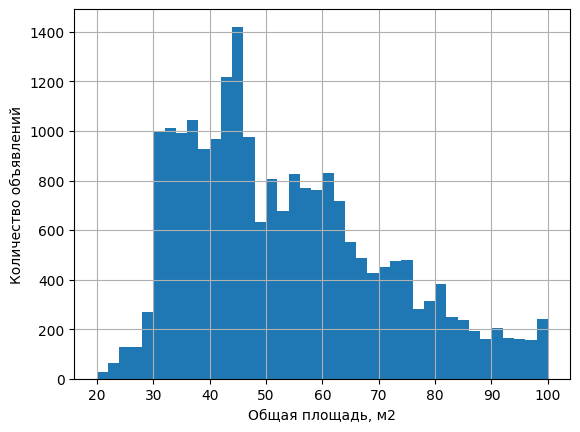

In [262]:
df_parameters.hist('total_area' , bins = 40 , range = (20, 100))
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

Наибольшее число квартир имеет площадь 45м2. Большая часть продаваемого жилья имеет площадь в пределах от 30 до 63м2. После отметки в 63 м2 идет постепенный спад. 

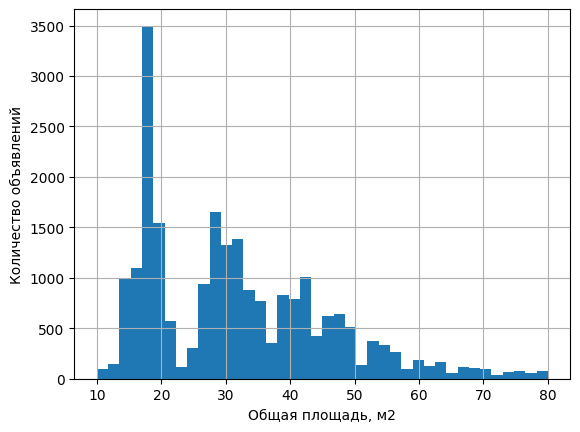

In [263]:
df_parameters.hist('living_area' , bins = 40 , range = (10, 80))
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

В зависимости от жилой площади, судя по графику, квартиры делятся на несколько групп. Первая группа - площади в пределах от 15 до 22 м2 с ярким пиком в 18 м2. Скорее всего это бюджетные однокомнатные квартиры. Вторая группа - площади от 25 до 35 м2. Пик значений в пределах от 28 до 32 м2. Третья группа - площади от 35 до 43 м2. 

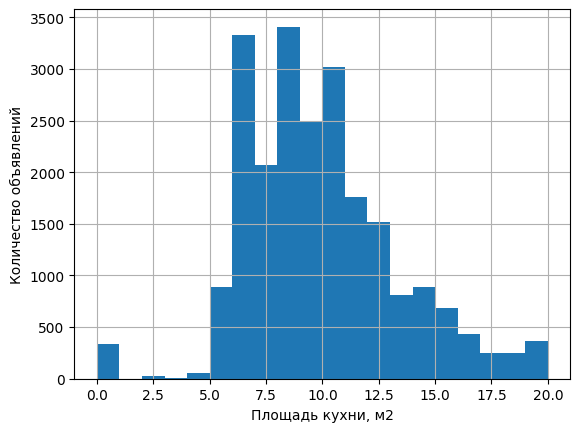

In [264]:
df_parameters.hist('kitchen_area' , bins = 20 , range = (0, 20));
plt.xlabel('Площадь кухни, м2')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

Большая часть площадей кухонь расположена в пределах 6-11 м2.

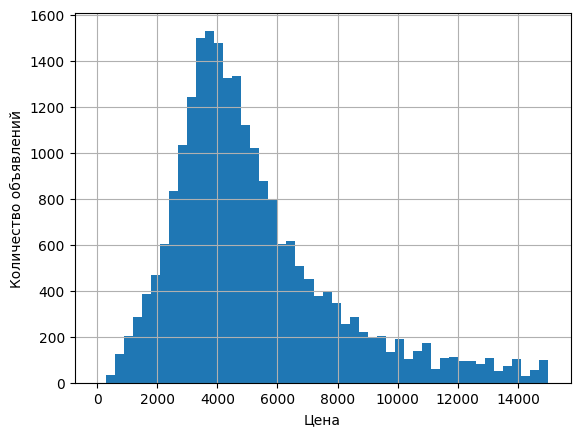

In [265]:
df_parameters.hist('last_price' , bins = 50 , range = (0, 15000))
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

Большая часть значений цен лежит в пределах 3.40-6.75 млн.руб с пиком в 4.6 млн.руб.

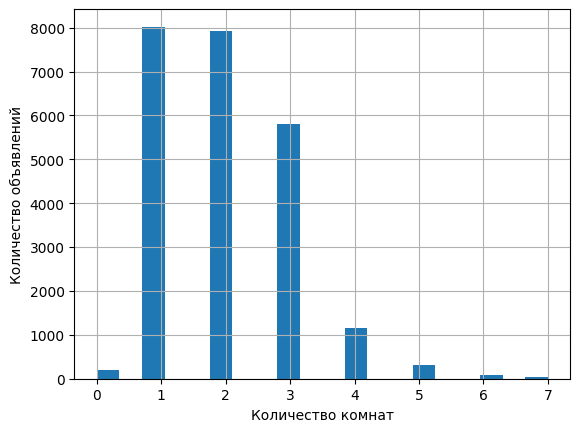

In [266]:
df_parameters.hist('rooms' , bins = 20 , range = (0, 7));
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

По количеству комнат, самыми распространенными являются однокомнатные и двухкомнатные квартиры - по 8 тысяч объявлений в каждой категории. Трехкомнатных немногим меньше - 5900. Четырехкомнатных - 1100. Остальные - до 500 объявлений.

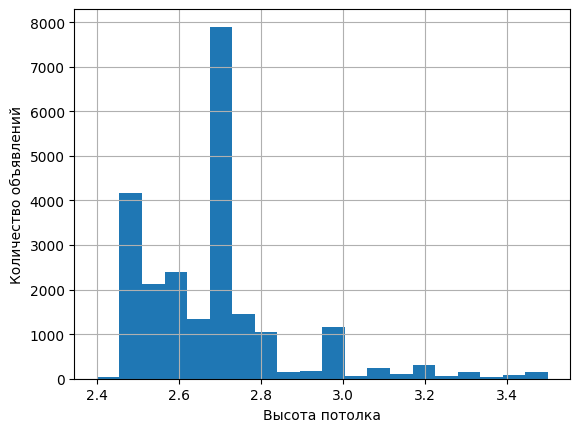

In [267]:
df_parameters.hist('ceiling_height' , bins = 20 , range = (2.4, 3.5));
plt.xlabel('Высота потолка')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

По высоте потолка имеются два пиковых значения - 2.45 и 2.7 метров.

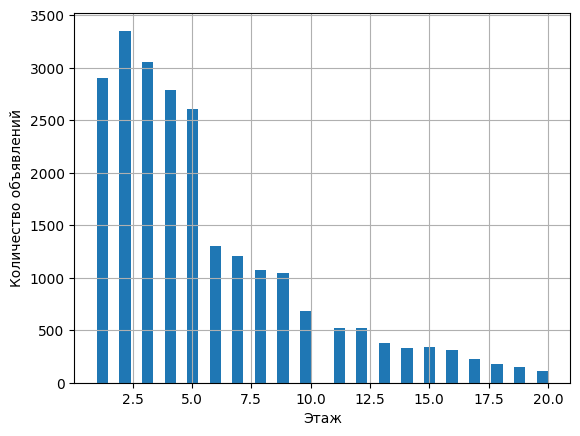

In [268]:
df_parameters.hist('floor' , bins = 40 , range = (1, 20));
plt.xlabel('Этаж')
plt.ylabel('Количество объявлений')
plt.title('')
plt.show()

По этажам - большая часть объявлений - с первого по пятый этажи. Квартир на втором этаже больше всего - 3250. Вероятно, наибольший вклад сюда вносят хрущевки.

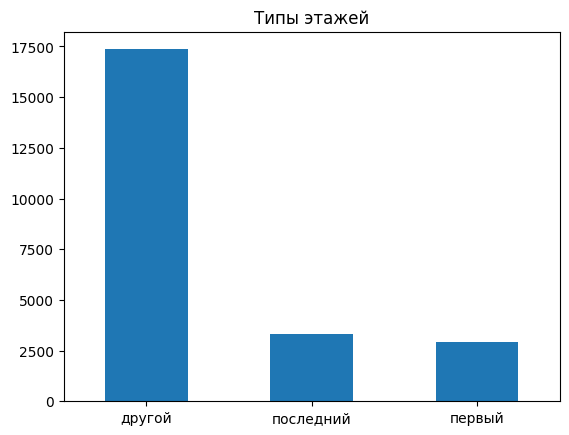

In [130]:
df_parameters.floor_types.value_counts().plot(kind='bar' , rot = 0);
plt.title('Типы этажей');

По типу этажей, большая часть объявлений не на первом и последнем этаже ~ 17500 объявлений.

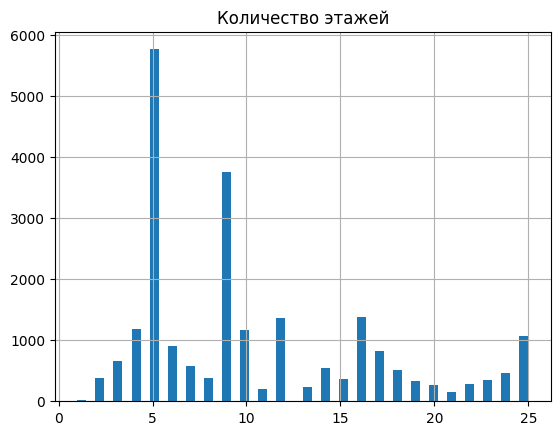

In [131]:
df_parameters.hist('floors_total' , bins = 50 , range = (1, 25));
plt.title('Количество этажей');

По количеству этажей наблюдаются пики в домах с пятью и девятью этажами - наиболее типичная застройка спальных районов.

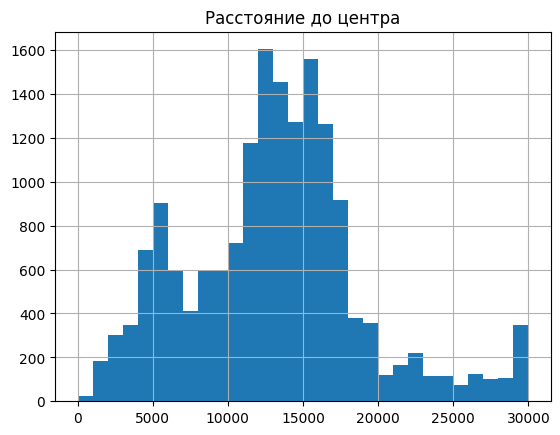

In [132]:
df_parameters.hist('cityCenters_nearest' , bins = 30 , range = (0, 30000));
plt.title('Расстояние до центра');

В зависимости от расстояния до центра есть две крупных категории. Первая - от 4 до 7.5 км - жилье в центре. И от 12 до 17.5 км - спальные районы.

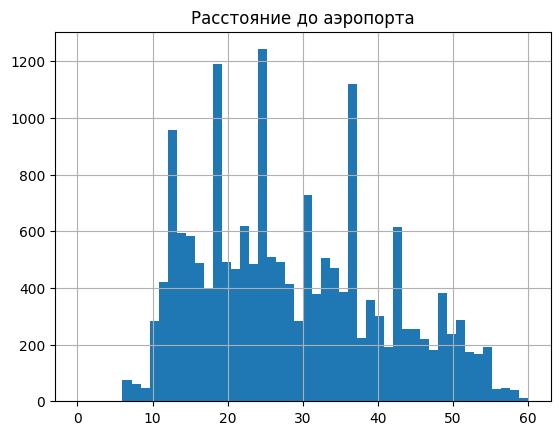

In [133]:
df_parameters.hist('airports_nearest' , bins = 50 , range = (0, 60));
plt.title('Расстояние до аэропорта');

По расстоянию до аэропорта распределение довольно равномерное. Имеются пики в 13,19, 25, 36 и 43 км.

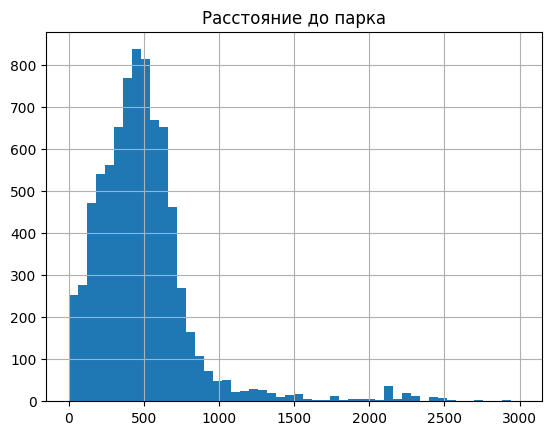

In [134]:
df_parameters.hist('parks_nearest' , bins = 50 , range = (0, 3000));
plt.title('Расстояние до парка');

По расстоянию до парка, основная часть объектов расположена в пределах от 0 до 750 метров до парка.

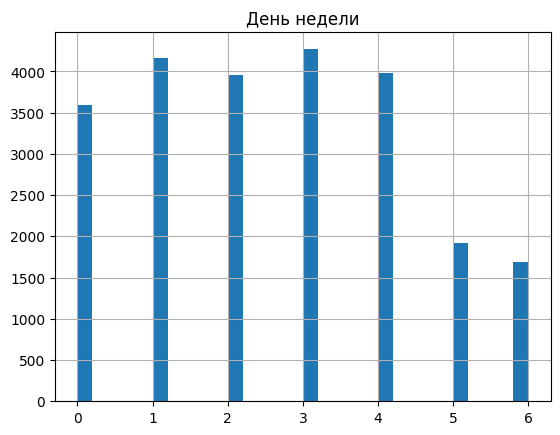

In [135]:
df_parameters.hist('day' , bins = 30 , range = (0, 6));
plt.title('День недели');

Большая часть объявлений выкладывается в будни и в два раза меньше- в выходные.

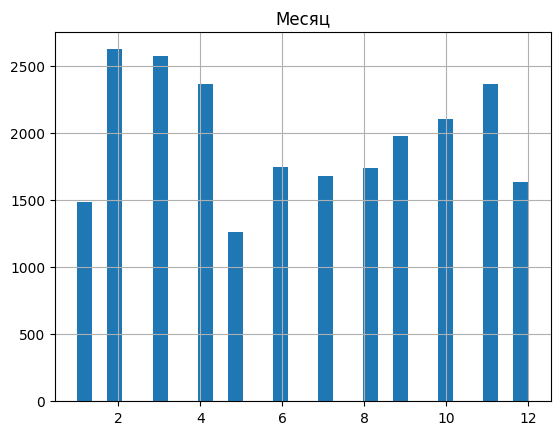

In [136]:
df_parameters.hist('month' , bins = 30 , range = (1, 12));
plt.title('Месяц');

Большая чатсь объявлений выкладывается в феврале и марте и ноябре. Меньшая - в мае.

### Быстрота продажи

In [137]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,median_living,median_kitchen,median_ceiling,square_meter_price,day,month,year,floor_types
0,20,13000.0,108,2019-03-07,3,2.7,16.0,51.0,8,False,...,755.0,NaN,61.0,15.0,2.7,120.4,3,3,2019,другой


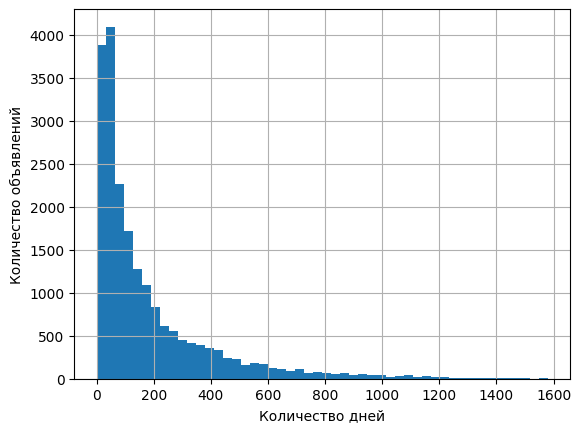

In [269]:
# Общая гистограмма
data['days_exposition'].hist(bins = 50)
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

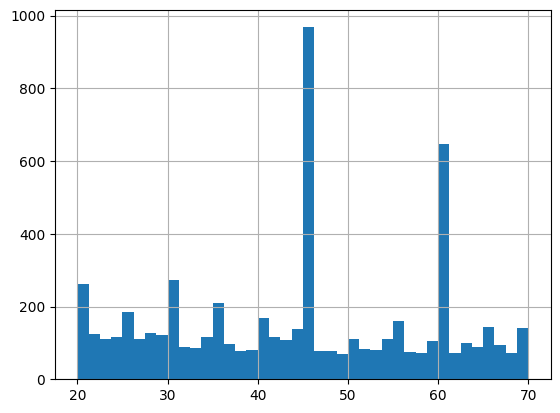

In [139]:
# Выявление пиков продаж
data['days_exposition'].hist(bins = 40 , range = (20, 70))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

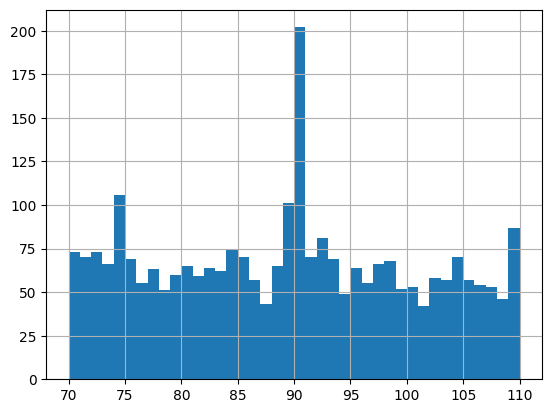

In [140]:
# Выявление спада продаж
data['days_exposition'].hist(bins = 40 , range = (70, 110))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

Виден небольшой пик в продажах на 91 дне.

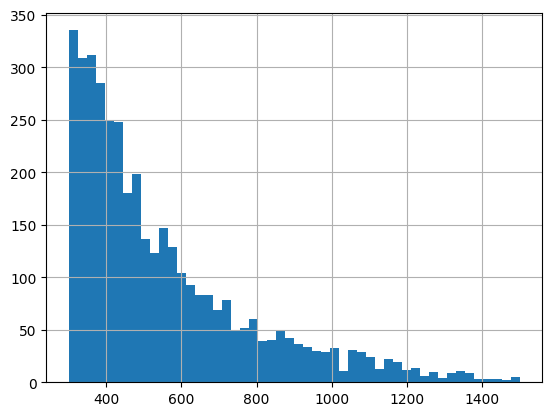

In [141]:
# Продолжение выявления спада продаж
data['days_exposition'].hist(bins = 50 , range = (300, 1500))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

In [142]:
data['days_exposition'].describe()

count    20413.000000
mean       180.554598
std        219.515989
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

В среднем, судя по значению медианы, большая часть продаж совершается за 95 дней. Есть пиковое значение на 45 и 60 днях. Данные продажи можно считать быстрыми. Также, обнаружен небольшой пик на 91 дне После 95 дней начинается постепенный спад, доходящий аж до 1580 дней. После ~600 дней продаж перестают резко снижаться. Считаю, что продажи занимающие более 1,5 лет можно считать необычайно долгими.

### Зависимость цены от параметров

        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год);


#### Общая площадь

In [143]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'median_living', 'median_kitchen',
       'median_ceiling', 'square_meter_price', 'day', 'month', 'year',
       'floor_types'],
      dtype='object')

Чтобы посмотреть зависимость, сгруппируем данные по общей площади и вычислим медианные значения цены.

In [144]:
total_sq_group = data.groupby('total_area')['last_price'].agg('median')
total_sq_group

total_area
12      2400.0
13      1768.0
14      1190.0
15      1725.0
16      2275.0
        ...   
320    14000.0
327    29000.0
336    28000.0
342    73900.0
348    36900.0
Name: last_price, Length: 263, dtype: float64

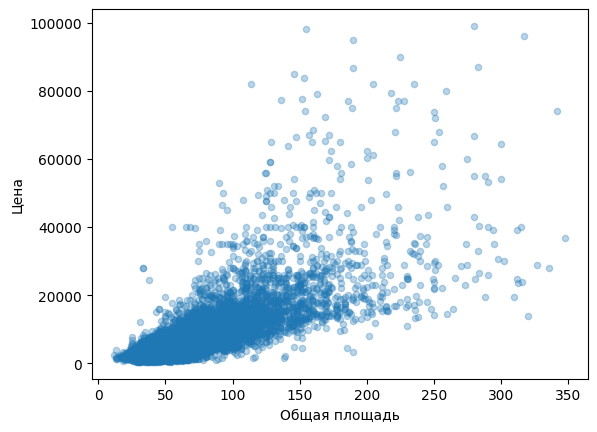

In [271]:
data.plot(x = 'total_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.3)
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.show()

In [272]:
# рассчитаем коэффициент корреляции между площадью и ценой
total_corr = data['total_area'].corr(data['last_price'])
total_corr

0.7571700473715449

В графике есть большие разбросы в квартирах с большими площадями, видимо осталось довольно много аномальных значений. Также, причиной разбросов может быть третий параметр влияющий на стоимость, например удаленность от центра. Квартиры с большой площадью, находящиеся далеко от центра,будут гораздо дешевле квартир в центре.

Тем не менее прослеживается зависимость между данными параметрами. Коэффициент корреляции также подтверждает это.

---

Ради интереса, посмотрю зависимость цены от общей площади в конкретном населенном пункте.

In [148]:
data['locality_name'].value_counts().head(3)

санкт-петербург    15636
мурино               589
кудрово              471
Name: locality_name, dtype: int64

В самом Питере наверняка будет наблюдаться подобная картина, поэтому возьму город поменьше - Мурино.

In [149]:
murino_check = data.query('locality_name == "мурино"')

In [150]:
murino_check.locality_name.unique()

array(['мурино'], dtype=object)

In [151]:
murino_check_group = murino_check.groupby('total_area')['last_price'].agg('median')

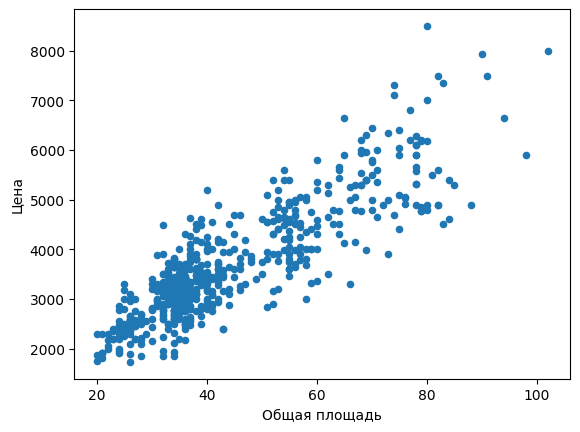

In [273]:
murino_check.plot(x = 'total_area' , y = 'last_price' , kind = 'scatter')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.show()

In [153]:
murino_check['total_area'].corr(murino_check['last_price'])

0.8643817827274773

Все таки картина немного поменялась - в графике меньше перепадов, коэффициент корреляции больше.

#### Жилая площадь

In [154]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'median_living', 'median_kitchen',
       'median_ceiling', 'square_meter_price', 'day', 'month', 'year',
       'floor_types'],
      dtype='object')

In [155]:
living_sq_group = data.groupby('living_area')['last_price'].agg('median')
living_sq_group

living_area
9.0       3490.30
10.0      3390.00
11.0      3304.25
12.0      3425.00
12.5      2050.00
           ...   
190.0    14000.00
193.0    30000.00
194.0    31950.00
195.0    55000.00
199.0    19500.00
Name: last_price, Length: 197, dtype: float64

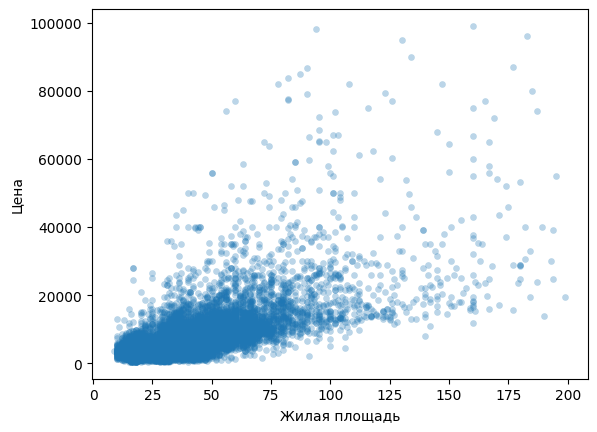

In [274]:
data.plot(x = 'living_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.3 , linewidth = 0.2)
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.show()

In [157]:
living_corr = data['living_area'].corr(data['last_price'])
living_corr

0.6734713227890639

Аналогичная ситуация и с жилой площадью - есть большие разбросы в квартирах с большими площадями.

Тем не менее  зависимость между данными параметрами прослеживается. Коэффициент корреляции ниже, чем в зависимости от общей площади, но он также подтверждает наличие зависимости.

#### Площадь кухни

In [158]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'median_living', 'median_kitchen',
       'median_ceiling', 'square_meter_price', 'day', 'month', 'year',
       'floor_types'],
      dtype='object')

In [159]:
kitchen_sq_group = data.groupby('kitchen_area')['last_price'].agg('median')
kitchen_sq_group

kitchen_area
0.0      2650.0
1.0      4250.0
1.5      2050.0
2.0      2050.0
3.0      3600.0
         ...   
58.0    28750.0
60.0    38650.0
62.0    40450.0
63.0    40000.0
64.0    10495.0
Name: last_price, Length: 71, dtype: float64

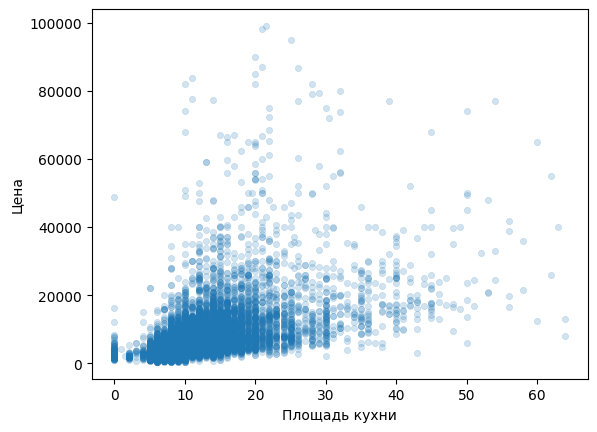

In [275]:
data.plot(x = 'kitchen_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.2 , linewidth = 0.5)
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.show()

In [162]:
kitchen_corr = data['kitchen_area'].corr(data['last_price'])
kitchen_corr

0.5628216431837925

В этом графике разбросов меньше, но они так же выделяются на фоне остального графика.

Тем не менее  зависимость между данными параметрами прослеживается. Коэффициент корреляции еще ниже, чем в зависимости от общей площади, но он также подтверждает наличие зависимости.

#### Количество комнат

In [164]:
data['rooms'].value_counts()

1     8022
2     7926
3     5797
4     1163
5      308
0      194
6       96
7       42
8        9
9        5
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64

Для более корректного вида графика, отсеку нулевые значения комнат и значения > 7.

In [165]:
rooms_group = data.query('0 < rooms < 8').groupby('rooms')['last_price'].agg('median')
rooms_group

rooms
1     3600.0
2     4770.0
3     6200.0
4     8990.0
5    13250.0
6    17504.3
7    20750.0
Name: last_price, dtype: float64

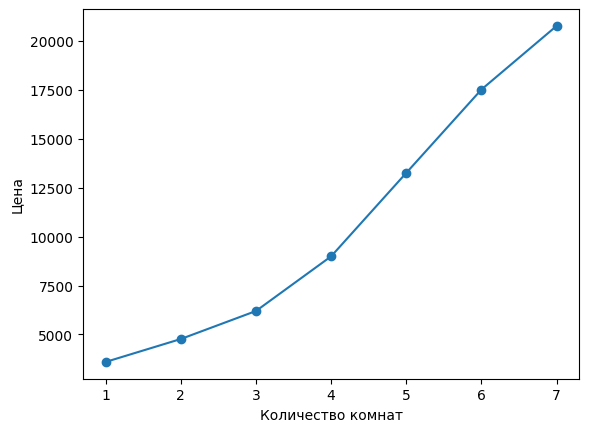

In [276]:
rooms_group.plot(x = 'rooms' , y = 'last_price' , kind = 'line' , style = 'o-')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

In [167]:
rooms_group.describe()

count        7.000000
mean     10723.471429
std       6614.991083
min       3600.000000
25%       5485.000000
50%       8990.000000
75%      15377.150000
max      20750.000000
Name: last_price, dtype: float64

In [168]:
rooms_corr = data['rooms'].corr(data['last_price'])
rooms_corr

0.46732308230960135

По графику прослеживается четкая зависимость.

Кэффициент корелляции ниже 0.5, значит зависимость средняя.

#### Тип этажа

In [169]:
floor_type_group = data.groupby('floor_types')['last_price'].agg('median')
floor_type_group

floor_types
другой       4800.2
первый       3900.0
последний    4300.0
Name: last_price, dtype: float64

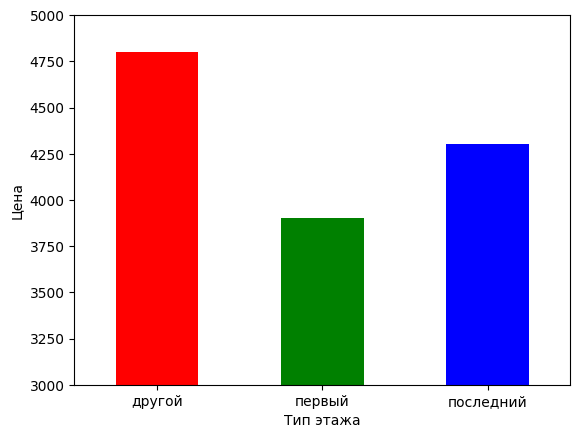

In [277]:
floor_type_group.plot(x = 'floor_types' , 
                      y = 'last_price' , 
                      kind = 'bar' , 
                      rot = 0 , 
                      color = ['r', 'g' , 'b'],
                     ylim = (3000, 5000))
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.show()

Судя по графику - первые этажи дешевле остальных, последние этажи немного дороже первых и самы дорогие - все остальные.

Поскольку тип этажей - категориальная переменная, расчитать корреляцию через коэффициент Пирсона методом `.corr()` - нельзя.

#### Дата публикации (день недели, месяц, год)

**День**

In [171]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'median_living', 'median_kitchen',
       'median_ceiling', 'square_meter_price', 'day', 'month', 'year',
       'floor_types'],
      dtype='object')

In [172]:
day_type_group = data.groupby('day')['last_price'].agg('median')
day_type_group

day
0    4650.0
1    4700.0
2    4700.0
3    4630.0
4    4550.0
5    4540.0
6    4550.0
Name: last_price, dtype: float64

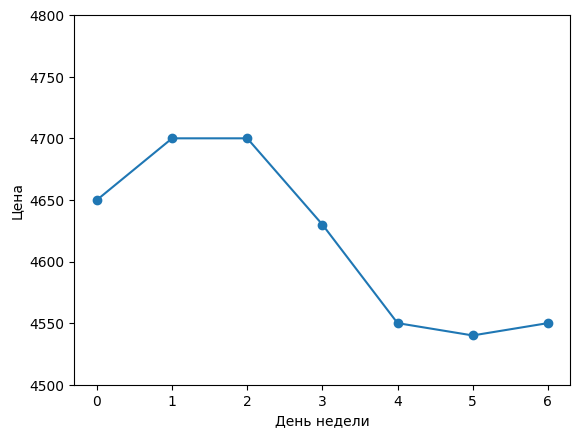

In [278]:
day_type_group.plot(x = 'day' , 
                    y = 'last_price' , 
                    kind = 'line' ,
                    style = 'o-' ,
                    rot = 0 , 
                    ylim = (4500 , 4800))
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()

Судя по графику, пиковая стоимость квартир приходится на вторник и в среду. В пт, сб и вс цена ниже всего.

**Месяц**

In [174]:
month_type_group = data.groupby('month')['last_price'].agg('median')
month_type_group

month
1     4600.0
2     4650.0
3     4650.0
4     4800.0
5     4500.0
6     4400.0
7     4650.0
8     4555.0
9     4690.0
10    4550.0
11    4700.0
12    4695.0
Name: last_price, dtype: float64

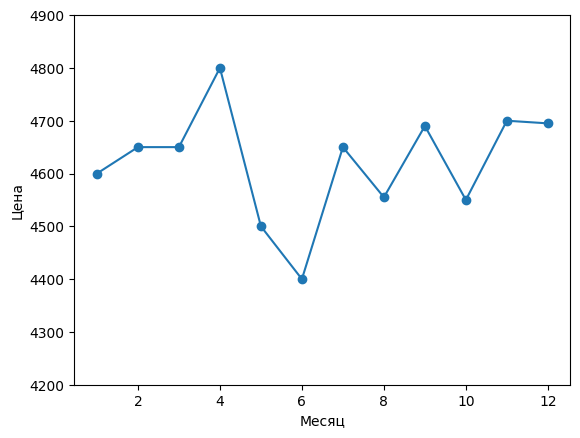

In [279]:
month_type_group.plot(x = 'month' , 
                      y = 'last_price' , 
                      kind = 'line' ,
                      style = 'o-' ,
                      rot = 0 , 
                      ylim = (4200 , 4900))
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.show()

В июне квартиры имеют наименьшую стоимость, далее цена повышается до пикового значения в мае.

**Год**

In [176]:
year_type_group = data.groupby('year')['last_price'].agg('median')
year_type_group

year
2014    7700.0
2015    5300.0
2016    4500.0
2017    4500.0
2018    4550.0
2019    5046.0
Name: last_price, dtype: float64

In [177]:
year_area_group = data.groupby('year')['total_area'].agg('median')

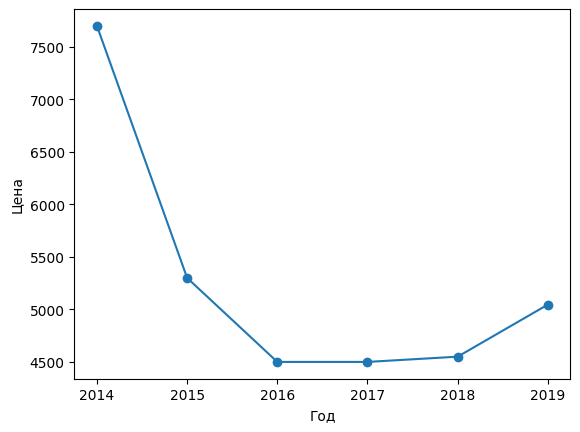

In [280]:
year_type_group.plot(x = 'year' , y = 'last_price' , kind = 'line' ,style = 'o-' ,rot = 0)
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

В 2014 году квартиры были наиболее дорогие, затем произошел резкий спад в цене. В 2016-2018 цена на квартиры почти не менялась и к 2019 начала постепенно увеличиваться.

Проверю, как изменялись другие параметры с течением времени, например, общая площадь.

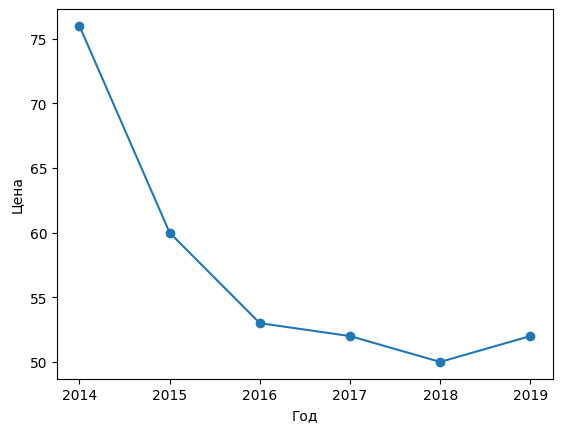

In [281]:
year_area_group.plot(x = 'year' , y = 'total_area' , kind = 'line' , style = 'o-')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

Площадь квартир так же снижается. То есть можно сделать вывод что падение цены с течением времени вызвано изменением параметров, вляющих на стоимость, которые мы рассматривали ранее, например, площадь.

### Цена м2 в 10 населенных пунктах

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [180]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'median_living', 'median_kitchen',
       'median_ceiling', 'square_meter_price', 'day', 'month', 'year',
       'floor_types'],
      dtype='object')

In [181]:
local_days_expo_grouped = data.groupby('locality_name')['last_price'].agg('count').reset_index()
(
    local_top = list(
        local_days_expo_grouped
        .sort_values(by = 'last_price', ascending = False)
        .head(10)['locality_name']
    )
)

In [182]:
local_top_data = data[data['locality_name'].isin(local_top)]

In [183]:
sq_m_price_group = local_top_data.groupby('locality_name')['square_meter_price'].agg('median').reset_index()
sq_m_price_group.sort_values(by = 'square_meter_price')

,locality_name,square_meter_price
1,выборг,58.3
0,всеволожск,65.8
2,гатчина,67.9
3,колпино,74.7
9,шушары,76.8
5,мурино,85.7
6,парголово,91.6
4,кудрово,95.6
7,пушкин,100.0
8,санкт-петербург,104.7


Выводы:   
* Самая низкая цена за квадратный метр в Выборге - 58.3 тыс.руб.   
* Самая высокая цена за квадратный метр в Санкт-Петербурге - 104.7 тыс.руб.

### Цена одного км

Теперь выделю квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислю среднюю цену каждого километра.

In [184]:
spb_km_prices = data[data['locality_name'] == 'санкт-петербург']

In [185]:
spb_km_prices = spb_km_prices[spb_km_prices['cityCenters_nearest'].notna()]

In [186]:
spb_km_prices['km_price'] = spb_km_prices['last_price'] / spb_km_prices['cityCenters_nearest']

In [187]:
spb_km_prices.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,median_living,median_kitchen,median_ceiling,square_meter_price,day,month,year,floor_types,km_price
0,20,13000.0,108,2019-03-07,3,2.70,16.0,51.0,8,False,...,NaN,61.0,15.0,2.7,120.4,3,3,2019,другой,812.500000
2,10,5196.0,56,2015-08-20,2,2.70,5.0,34.0,4,False,...,558.0,33.0,8.0,2.7,92.8,3,8,2015,другой,371.142857
3,0,64900.0,159,2015-07-24,3,2.70,14.0,95.0,9,False,...,424.0,95.0,16.0,2.7,408.2,4,7,2015,другой,9271.428571
4,2,10000.0,100,2018-06-19,2,3.03,14.0,32.0,13,False,...,121.0,57.0,15.0,2.7,100.0,1,6,2018,другой,1250.000000
7,5,7915.0,72,2019-04-18,2,2.70,24.0,43.0,22,False,...,NaN,43.0,9.0,2.7,109.9,3,4,2019,другой,659.583333


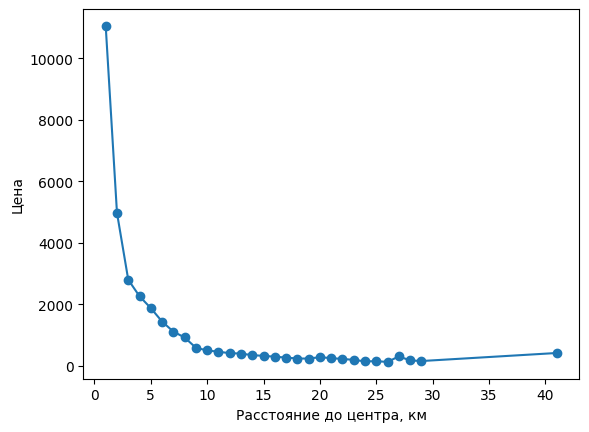

In [284]:
(
    spb_km_prices
    .groupby('cityCenters_nearest')['km_price']
    .agg('median').reset_index()
    .plot(x = 'cityCenters_nearest', 
          y = 'km_price', 
          kind = 'line', style = 'o-', rot = 0, legend= False)
)
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена')
plt.show()

In [189]:
ccentre_corr = data['cityCenters_nearest'].corr(data['last_price'])
ccentre_corr

-0.3080662353438375

Чем дальше от центра, тем ниже стоимость.

При удалении из центра на 5 км, цена понижается в 6 раз. Дальнейшее снижение цены происходит гораздо медленнее.

Коэффициент Пирсона показывает слабую обратную зависимость.

## Общий вывод

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Предобработка

Прежде всего была проведена предобработка данных. В ходе предобработки было выявлено множество аномальных и ошибочных значений и сделаны следующие выводы:
* При обработке цен были удалены аномально высокие значения и исправлено аномально низкое. После обработки гистограмма с ценами приобрела вид нормального распределения.Гистограммы показывают логичное понижение количества объявлений с увеличением цены. Наибольшее количество объявлений находится в пределах 3-5 млн.руб.
* При обработке данных об общей и жилой площади были удалены аномально высокие и низкие значения. Поскольку, текущая норма жилой площади на человека в СПб составляет 9 кв. метров для жильцов отдельных квартир, объявления со значениями менее 9кв.м. были отсечены. Графики показали, что большая часть площадей находится в промежутке от 15 до 75м2. Вероятно, жилье с жилой площадью более 75м2 является элитным жильем. Пропущенные значения заполнял медианным значением жилой площади от общей площади. Пиковые средние значения жилой площади составляют 19 и 30м2, для общей площади - промежуток 30-45м2.
* При обработке данных о потолках, кроме аномальных значений, были выявлены и ошибочные - некоторые значения имели явную ошибку в порядках. Данные были исправлены. Объявления с потолками высотой более 6 метров и менее 2 метров были удалены, поскольку не вписываются в нормы. Среднее значение высоты потолка для большинства объявлений -  2.4-2.8 м. Пропуски в значениях высоты потолков были заполнены медианными значениями по населенным пунктам. 
* Формат даты расстояни до центра и аэропорта был изменен на удобочитаемый.
* Пропущенные значения балконов были изменены на нули. Также, была обнаружена вероятная ошибка в количестве балконов. Есть множество объявлений квартир с небольшой площадью и 4-5 балконами. Считаю, что это ошибочные данные.
* В столбце апартаменты были обработаны пропущенные значения. Пропуски связаны с тем, что при заполнении заявки на размещение объявления на сайте, пользователь просто пропускал данную строку, поскольку его объект не является апартаментами.
* В столбце площадь были обработаны пропущенные значения и удалены аномальные. Часть пропусков объяснялась типом жилого помещения. В жилом помещении со свободной планировкой и в квартире-студии нет обособленной кухни, они входят в общую площадь. Пропуски заменены на нули. Остальные пропуски были заполнены по медианным значениям площадей, сгруппированным по общей площади помещения.
* В с комнатами имелись аномально высокие значения - 8-16 комнат. Также имелись квартиры с нулем комнат - эти квартиры имели тип апартаменты, свободная планировка и студия. Аномальные и нулевые значения не учитывались при последующем исследовании.
* В ходе предобработки населенных пунктов были выявлены и обработаны неявные дубликаты. Также были заполнены пропущенные значения

### Исследуемые параметры

В начале исследования, прежде всего ознакомились с исследуемыми параметрами, изучили гистограммы:

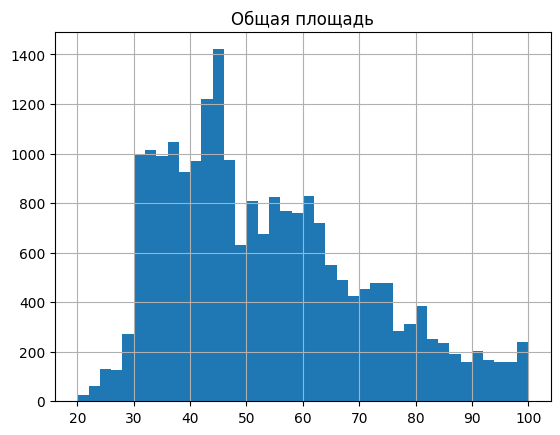

In [190]:
df_parameters.hist('total_area' , bins = 40 , range = (20, 100));
plt.title('Общая площадь');

Наибольшее число квартир имеет площадь 45м2. Большая часть продаваемого жилья имеет площадь в пределах от 30 до 63м2. После отметки в 63 м2 идет постепенный спад. 

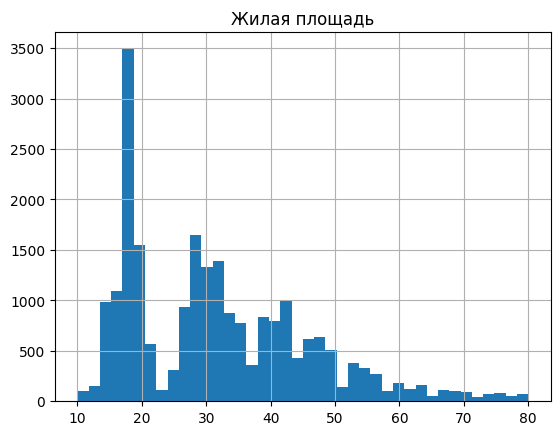

In [191]:
df_parameters.hist('living_area' , bins = 40 , range = (10, 80));
plt.title('Жилая площадь');

В зависимости от жилой площади, судя по графику, квартиры делятся на несколько групп. Первая группа - площади в пределах от 15 до 22 м2 с ярким пиком в 18 м2. Скорее всего это бюджетные однокомнатные квартиры. Вторая группа - площади от 25 до 35 м2. Пик значений в пределах от 28 до 32 м2. Третья группа - площади от 35 до 43 м2. 

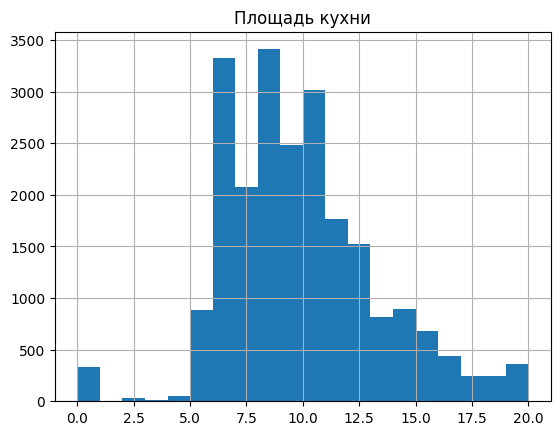

In [192]:
df_parameters.hist('kitchen_area' , bins = 20 , range = (0, 20));
plt.title('Площадь кухни');

Большая часть площадей кухонь расположена в пределах 6-11 м2.

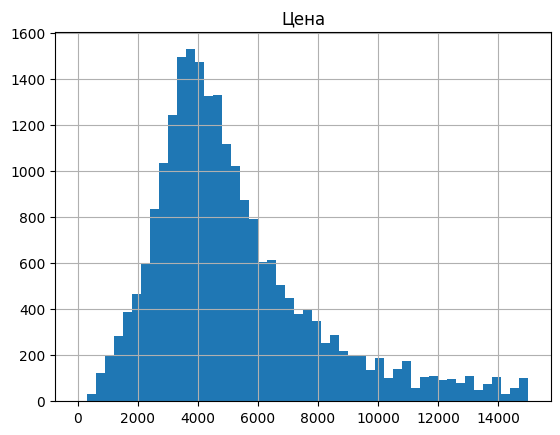

In [193]:
df_parameters.hist('last_price' , bins = 50 , range = (0, 15000));
plt.title('Цена');

Большая часть значений цен лежит в пределах 3.40-6.75 млн.руб с пиком в 4.6 млн.руб.

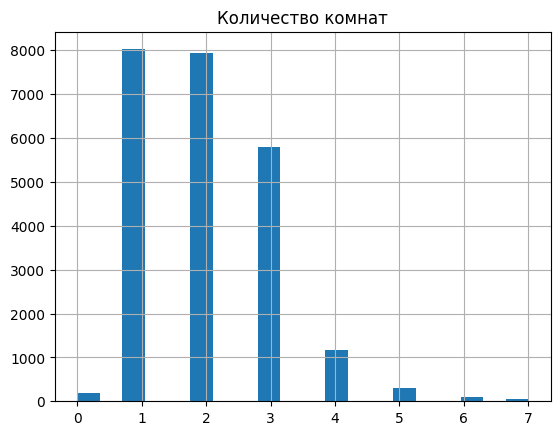

In [194]:
df_parameters.hist('rooms' , bins = 20 , range = (0, 7));
plt.title('Количество комнат');

По количеству комнат, самыми распространенными являются однокомнатные и двухкомнатные квартиры - по 8 тысяч объявлений в каждой категории. Трехкомнатных немногим меньше - 5900. Четырехкомнатных - 1100. Остальные - до 500 объявлений.

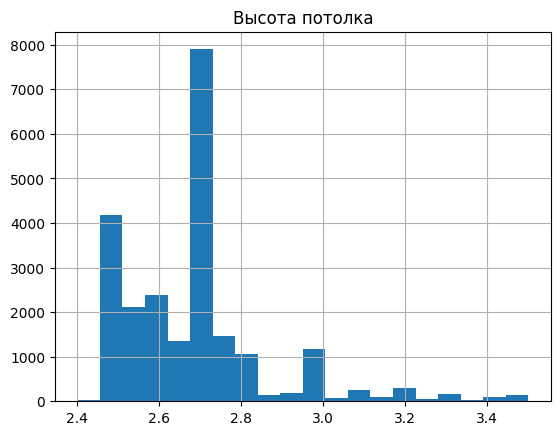

In [195]:
df_parameters.hist('ceiling_height' , bins = 20 , range = (2.4, 3.5));
plt.title('Высота потолка');

По высоте потолка имеются два пиковых значения - 2.45 и 2.7 метров.

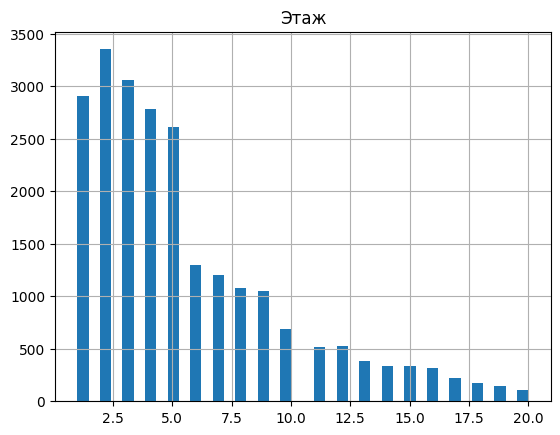

In [196]:
df_parameters.hist('floor' , bins = 40 , range = (1, 20));
plt.title('Этаж');

По этажам - большая часть объявлений - с первого по пятый этажи. Квартир на втором этаже больше всего - 3250. Вероятно, наибольший вклад сюда вносят хрущевки.

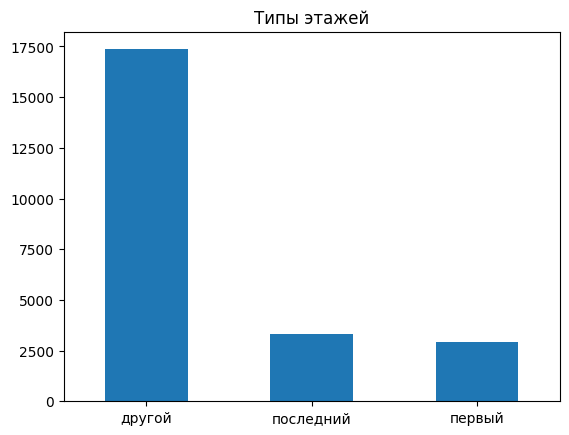

In [285]:
df_parameters.floor_types.value_counts().plot(kind='bar' , rot = 0);
plt.title('Типы этажей');

По типу этажей, большая часть объявлений не на первом и последнем этаже ~ 17500 объявлений.

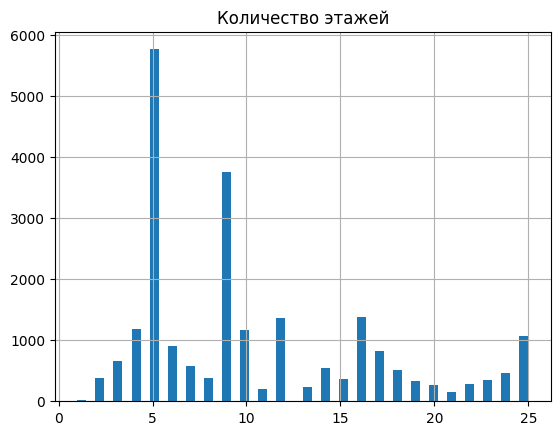

In [198]:
df_parameters.hist('floors_total' , bins = 50 , range = (1, 25));
plt.title('Количество этажей');

По количеству этажей наблюдаются пики в домах с пятью и девятью этажами - наиболее типичная застройка спальных районов.

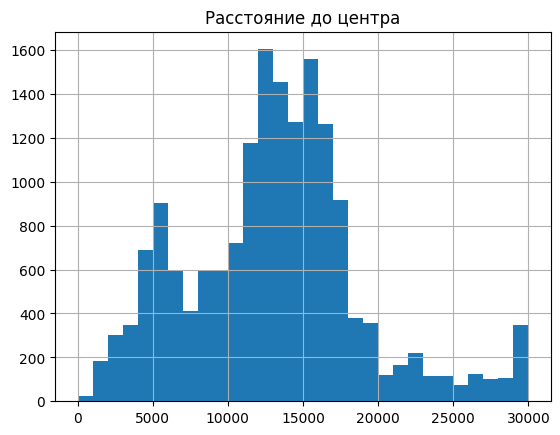

In [199]:
df_parameters.hist('cityCenters_nearest' , bins = 30 , range = (0, 30000));
plt.title('Расстояние до центра');

В зависимости от расстояния до центра есть две крупных категории. Первая - от 4 до 7.5 км - жилье в центре. И от 12 до 17.5 км - спальные районы.

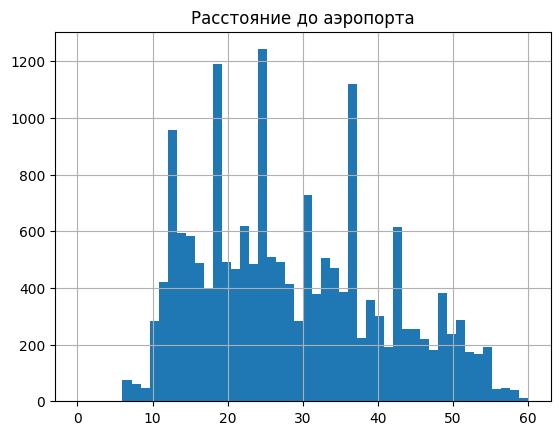

In [200]:
df_parameters.hist('airports_nearest' , bins = 50 , range = (0, 60));
plt.title('Расстояние до аэропорта');

По расстоянию до аэропорта распределение довольно равномерное. Имеются пики в 13,19, 25, 36 и 43 км.

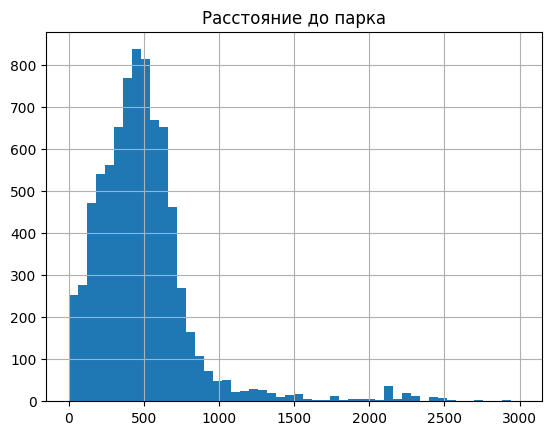

In [201]:
df_parameters.hist('parks_nearest' , bins = 50 , range = (0, 3000));
plt.title('Расстояние до парка');

По расстоянию до парка, основная часть объектов расположена в пределах от 0 до 750 метров до парка.

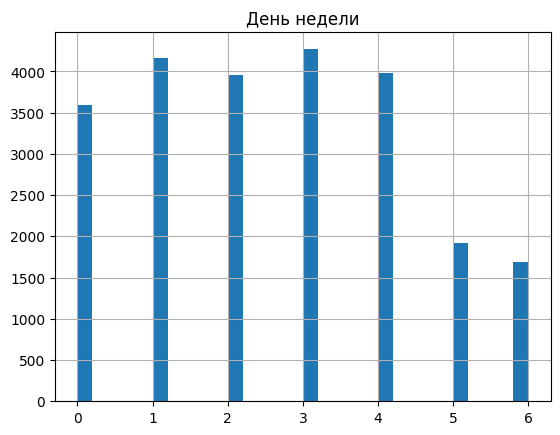

In [202]:
df_parameters.hist('day' , bins = 30 , range = (0, 6));
plt.title('День недели');

Большая часть объявлений выкладывается в будни и в два раза меньше- в выходные.

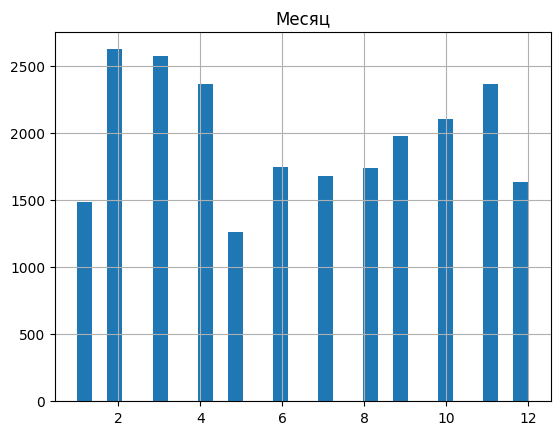

In [203]:
df_parameters.hist('month' , bins = 30 , range = (1, 12));
plt.title('Месяц');

Большая чатсь объявлений выкладывается в феврале и марте и ноябре. Меньшая - в мае.

Исследовали на динамику продаж и определили, какие продажи считаются **быстрыми**, а какие необычайно **долгими**.

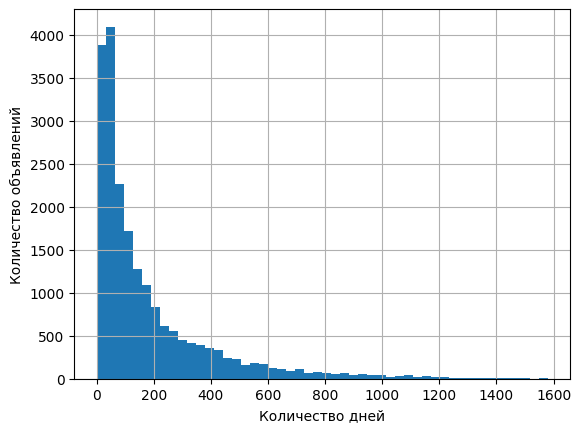

In [289]:
data['days_exposition'].hist(bins = 50)
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

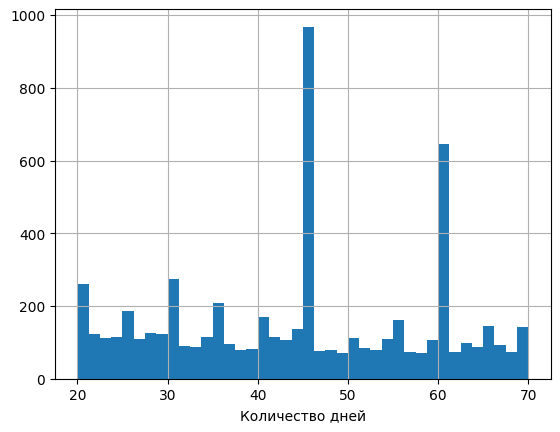

In [287]:
data['days_exposition'].hist(bins = 40 , range = (20, 70))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

Видны пиковые значения на 45 и 60 днях

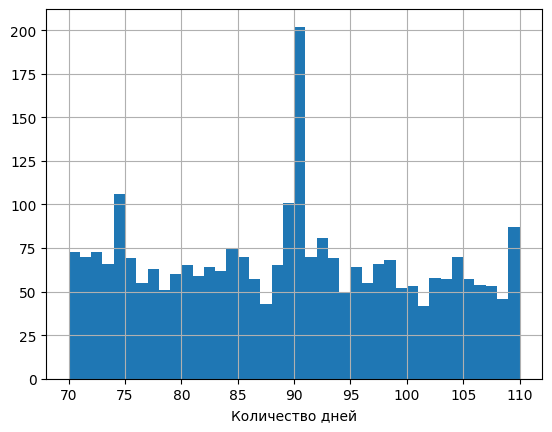

In [288]:
data['days_exposition'].hist(bins = 40 , range = (70, 110))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

Виден небольшой пик в продажах на 91 дне.

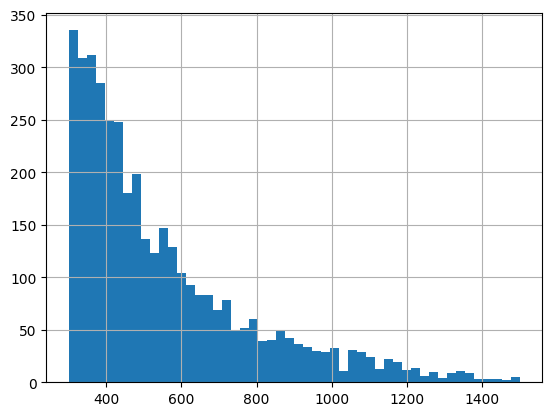

In [207]:
# Продолжение выявления спада продаж
data['days_exposition'].hist(bins = 50 , range = (300, 1500))
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

В среднем, судя по значению медианы, большая часть продаж совершается за 95 дней. Есть пиковое значение на 45 и 60 днях. Данные продажи можно считать быстрыми. Также, обнаружен небольшой пик на 91 дне После 95 дней начинается постепенный спад, доходящий аж до 1580 дней. После ~600 дней продаж перестают резко снижаться. Считаю, что продажи занимающие более 600 дней можно считать необычайно долгими.

### Исследование зависимостей

Далее были определены параметры влияющие на стоимость квартиры.

Сильнее всего на стоимость квартиры влияет **общая площадь квартиры**.

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


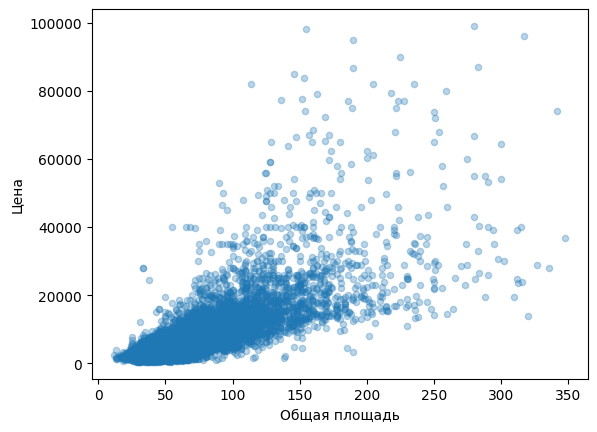

In [290]:
data.plot(x = 'total_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.3)
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.show()

В графике есть большие разбросы в квартирах с большими площадями, видимо осталось довольно много аномальных значений. Также, причиной разбросов может быть третий параметр влияющий на стоимость, например удаленность от центра. Квартиры с большой площадью, находящиеся далеко от центра,будут гораздо дешевле квартир в центре.

Коэффициент корелляции составляет 0.76.

Аналогичная ситуация и с **жилой площадью** - есть большие разбросы в квартирах с большими площадями.

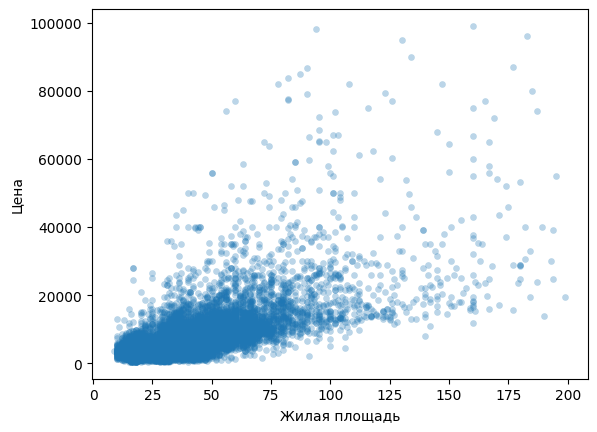

In [291]:
data.plot(x = 'living_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.3 , linewidth = 0.2)
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.show()

Тем не менее  зависимость между данными параметрами прослеживается. Коэффициент корреляции ниже, чем в зависимости от общей площади, но он также подтверждает наличие зависимости.

Коэффициент корелляции составляет 0.67.

Похожая ситуация наблюдается с **площадью кухни**.

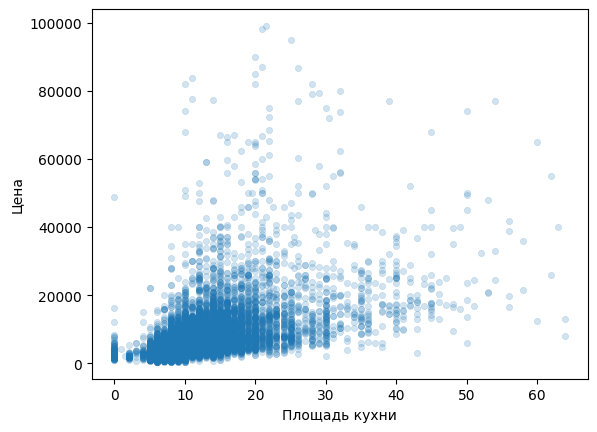

In [292]:
data.plot(x = 'kitchen_area' , y = 'last_price' , kind = 'scatter' , alpha = 0.2 , linewidth = 0.5)
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.show()

Чем больше площадь, тем выше стоимость. При увеличении площади в 4 раза, стоимость повышается приблизительно в 4 раза, то есть почти что прямопропорциональная зависимость.

Коэффициент корелляции составляет 0.56.

В случае с количеством комнат, также прослеживается зависимость

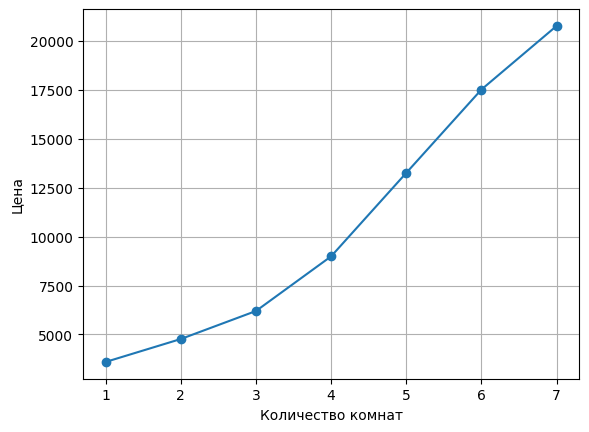

In [293]:
rooms_group.plot(x = 'rooms' , y = 'last_price' , kind = 'line' , style = 'o-' , grid = True)
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

Средняя цена однокомнатных квартир - 2.4 млн.руб, двухкомнантных - 5.0 млн.руб., трехкомнтаных - 7 млн.руб, четырехкомнтаных - 9 млн.руб.

Далее, повышая количество комнат, цена возрастает еще стремительнее: 13 млн.руб за пятикомнатную, 17.5 млн.руб за шестикомнатную и 21 млн.руб за семикомнтаную. 

Для **типов этажей** наблюдается следующая зависимость.

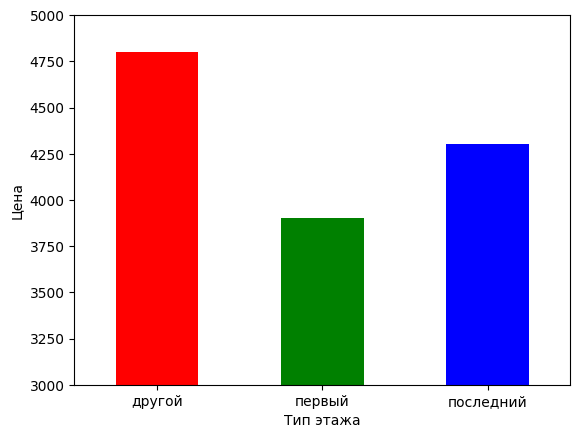

In [294]:
floor_type_group.plot(x = 'floor_types' , y = 'last_price' , 
                      kind = 'bar' , rot = 0 , 
                      color = ['r', 'g' , 'b'], ylim = (3000, 5000))
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.show()

Первые этажи дешевле остальных, их средняя стоимость составляет 3.9 млн.руб. 

Последние этажи немного дороже первых, их средняя стоимость составляет 4.3 млн.руб.,  и самые дорогие - все остальные - 4.75 млн.руб.

В зависимости от **даты** наблюдается следующая картина.

* Для дней недели:

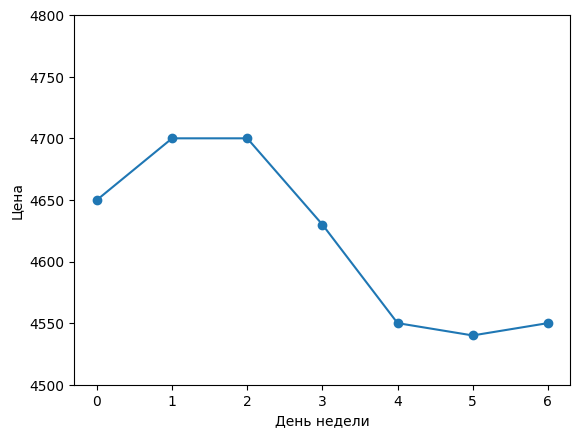

In [295]:
day_type_group.plot(x = 'day' , y = 'last_price' , 
                    kind = 'line' ,style = 'o-' ,rot = 0 , 
                    ylim = (4500 , 4800))
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()

Пиковая стоимость квартир приходится на вторник и в среду - 4.7 млн.руб. 

В пятницу, субботу и воскресенеие цена ниже всего - 4.55 млн.руб.

Зависимость есть, но она слабая.

* зависимость от месяца:

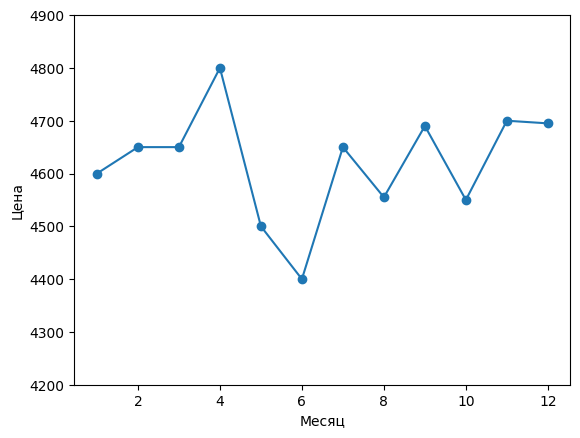

In [296]:
month_type_group.plot(x = 'month' , y = 'last_price' , 
                      kind = 'line' ,style = 'o-' ,rot = 0 , 
                      ylim = (4200 , 4900))
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.show()

В июне квартиры имеют наименьшую стоимость - 4.4 млн.руб., далее цена повышается до пикового значения в мае - 4.8 млн.руб.

* зависимость от года:

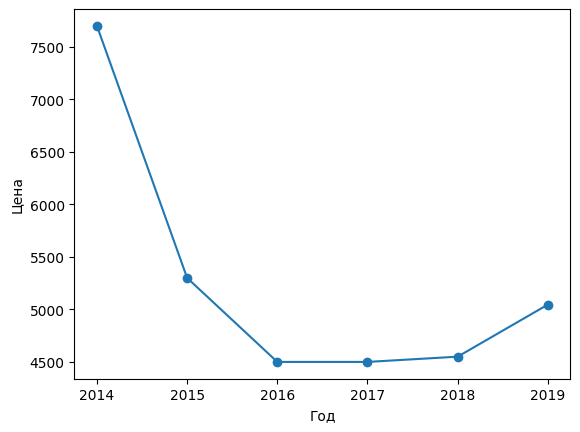

In [297]:
year_type_group.plot(x = 'year' , y = 'last_price' , 
                     kind = 'line' ,style = 'o-' ,rot = 0)
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

В 2014 году квартиры были наиболее дорогие - 7.7 млн.руб., затем произошел резкий спад в цене. В 2016-2018 цена на квартиры почти не менялась и оставалась в пределах 4.5 млн.руб и к 2019 начала постепенно увеличиваться до 5 млн.руб.

Проверка, как изменялись другие параметры с течением времени, например, общая площадь, показала следующие результаты:

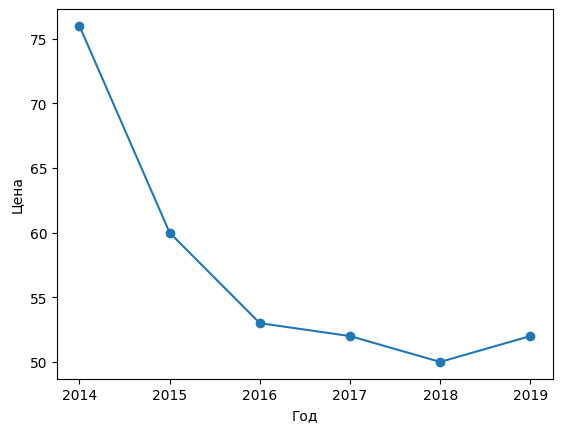

In [298]:
year_area_group.plot(x = 'year' , y = 'total_area' , kind = 'line' , style = 'o-')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

Площадь квартир так же снижается. То есть можно сделать вывод что падение цены с течением времени вызвано изменением параметров, вляющих на стоимость, которые мы рассматривали ранее, например, площадь и рассматривать прямое влияние года на стоимость без учета прочих параметров нельзя.

При расчете средней цены квадратного метра в зависимости от населенного пункта и количества объявлений, получили следующие результаты:

* самая низкая цена за квадратный метр в Выборге - 58.3 тыс.руб.

* самая высокая цена за квадратный метр в Санкт-Петербурге - 104.7 тыс.руб.

При расчете зависимости стоимости квартиры от удаленности от центра получили следующие результаты:

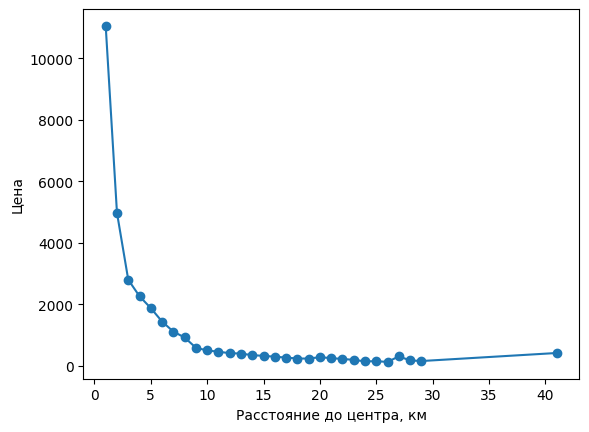

In [299]:
(
    spb_km_prices
    .groupby('cityCenters_nearest')['km_price']
    .agg('median').reset_index()
    .plot(x = 'cityCenters_nearest', y = 'km_price' , 
          kind = 'line' ,style = 'o-' ,rot = 0, legend= False)
)
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена')
plt.show()

Чем дальше от центра, тем ниже стоимость.

При удалении из центра на 5 км, цена понижается в 6 раз, с 12 до 2 млн.руб. Дальнейшее снижение цены происходит гораздо медленнее.

Коэффициент Пирсона равен -0.31 и показывает слабую обратную зависимость.